# Objective: To build a model in order to predict churn customers for a given telecom company and to get top driving features to derive customer retaintion statergy

#### INDEX
* [Data Sourcing](#Data-Sourcing)
* [Data cleaning](#Data-cleaning)
* [Zoning in on high value customers](#Zoning-in-on-high-value-customers)
* [Deriving Churn / target variable](#Deriving-Churn-/-target-variable)
* [Checking for class imbalance](#Checking-for-class-imbalance)
* [Feature engineering](#Feature-engineering)
* [EDA and data visualization](#EDA-and-data-visualization)
* [Data preparation for modelling](#Data-preparation-for-modelling)
    * [Handling class imbalance](#Handling-class-imbalance)
* [Model building for classification](#Model-building-for-classification)
    * For interpretibility:
        * [Simple logit model](#Simple-Logistic-model)
        * [Simple DT](#Simple-Decision-Tree-model)
        * [Simple RF (with smote sampling)](#Simple-Random-Forest-model-with-smote)
        * [Simple RF (with class weight parameter)](#Simple-Random-Forest-model-with-class-weight)
    * For strong prediction:
        * [Logit with PCA](#Logit-model-with-PCA)
        * [RF with PCA](#Random-forest-with-PCA)
* [Conclusion](#Conclusion)

In [1]:
#Importing liabraries for data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re                    #For regular expressions 
import missingno as msno              #To visualize missing values in dataframe.
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing ML liabraries  
from sklearn.model_selection import train_test_split           #For splitting into train-test set.
from sklearn.preprocessing import StandardScaler,MinMaxScaler  #For scaling.
from sklearn.ensemble import RandomForestClassifier            #To build a RandomForest model for classification.
from sklearn.linear_model import LogisticRegression            #To build a Logit model for classification.
from imblearn.over_sampling import SMOTE                       #Oversampling to handle class imbalance.
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score      #Metrics for model evaluation.
from sklearn.metrics import confusion_matrix                   #Metrics for model evaluation.
from sklearn.feature_selection import RFE                      #For feature selection.
import statsmodels.api as sm                                   #For Generalized Linear Model Regression Results.
from statsmodels.stats.outliers_influence import variance_inflation_factor  #To measure Multicollinearity.
from sklearn.metrics import plot_roc_curve                     #To plot ROC curve.
from sklearn.model_selection import GridSearchCV               #for hyperparameter tuning using GridsearchCV .
from sklearn.decomposition import PCA                          #To get principal components.  
from sklearn.tree import DecisionTreeClassifier                #To build DT model

In [3]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

* Functions for plotting and to calculate missing value percentage, metrics such as VIF etc. :

In [4]:
#Returns features with missing values, missing value percentages of features and dict with mapping of both. 
def missing_percent_calc(df):      
    missing_percent = round(df.isnull().sum()/len(df.index)*100,2)
    missing_features = missing_percent[missing_percent != 0].sort_values(ascending=False)
    missing_features_dict = missing_features.to_dict()
    return missing_percent,missing_features,missing_features_dict

In [5]:
# Plots ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [6]:
#Returns various metrics for DT along with ROC curve
def evaluate_model(dt_classifier):    
    print("Train Recall :", recall_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test recall :", recall_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))
    draw_roc(y_test, dt_classifier.predict(X_test))
    plt.show()

In [7]:
#Plots DT
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Churn', "No Churn"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

## Data Sourcing
    *We have dataset of customer behaiour for the months of June,July,august and september for given telco.
    *Using June,July,august month data we have to predict which customers will churn in september.
    *This is a supervised Learning problem.

In [8]:
df = pd.read_csv(r"C:\Users\ADMIN\Downloads\telecom_churn_data.csv")
pd.set_option('display.max_columns',len(df.columns)) #Displays all the columns of dataframe in the output.
print(f'Dataframe has total {df.shape[0]} records and {df.shape[1]} number of initial features.')

Dataframe has total 99999 records and 226 number of initial features.


In [9]:
df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

<AxesSubplot:>

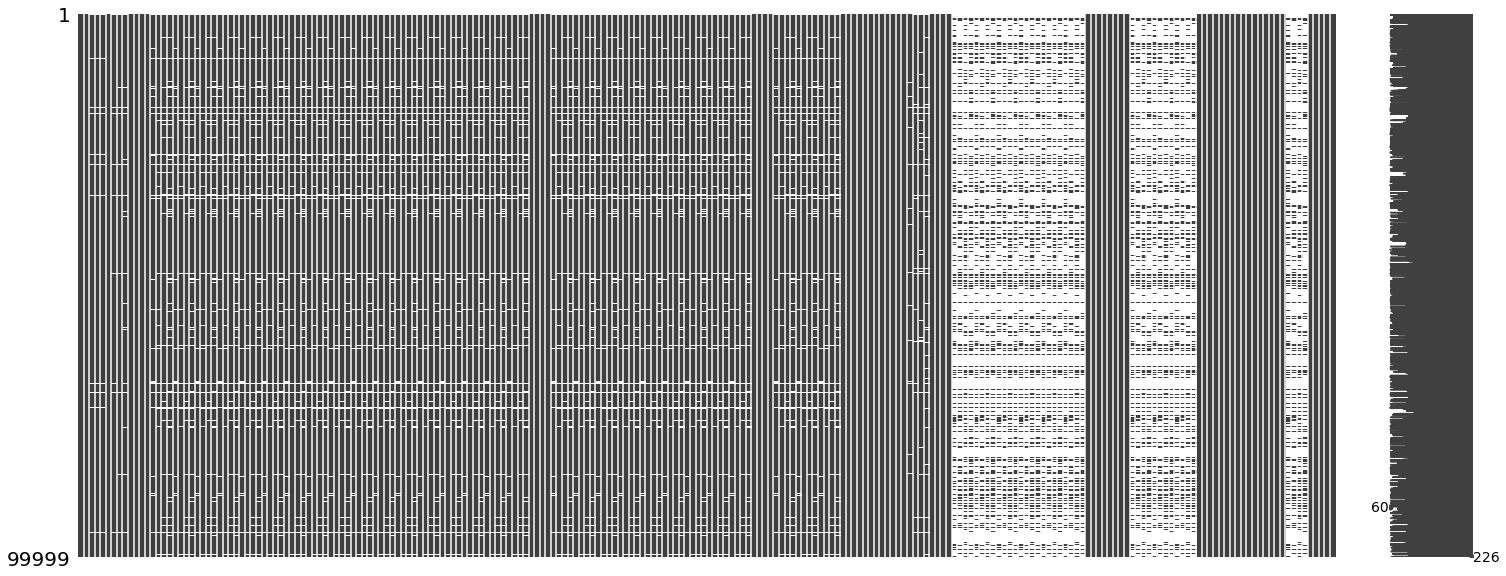

In [10]:
#Visualizing missing values in a dataframe.
msno.matrix(df)

* From above plot we can see that we have very large number of null values.

In [11]:
df_copy = df.copy()  #Making copy of original before modifying the dataframe.

In [12]:
df.info()            #To check data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


* Initially out of 226 features, we have 12 features as dtype as object, 179 features as dtype as float and 35 features as dtype as int.

## Data cleaning

In [13]:
# Removing duplicate rows if any:
df.drop_duplicates(inplace=True)
df.shape

(99999, 226)

In [14]:
# Checking unique value count for mobile number feature
print(f'mobile number feature has {df.mobile_number.nunique()} unique values') #All values unique

mobile number feature has 99999 unique values


In [15]:
# Checking unique value count for circle id feature
print(f'circle id feature has only {df.circle_id.nunique()} unique value') #All values same

circle id feature has only 1 unique value


    Removing features that are insignificant for analysis:
    * We are taking judgement call to drop mobile number and circle id as they are not much helpful 
    for prediction in our case.

In [16]:
df.drop(['mobile_number','circle_id'],axis=1,inplace=True) # Dropping mobile_number feature

In [17]:
# Analysing date columns:
date_features=df.filter(regex=r'date',axis=1).columns  # Extracting date columns
df[date_features].head()

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9 date_of_last_rech_6 date_of_last_rech_7  \
0            9/30/2014           6/21/2014           7/16/2014   
1            9/30/2014           6/29/2014           7/31/2014   
2            9/30/2014           6/17/2014           7/24/2014   
3            9/30/2014           6/28/2014           7/31/2014   
4            9/30/2014           6/26/2014           7/28/2014   

  date_of_last_rech_8 date_of_last_rech_9 date_of_last_rech_data_6  \
0            8/8/2014           9/28/2014                6/21/2014   
1           8/28/2014           9/30/2014                      NaN   
2           8/14/2014           9/29/2014                      NaN   
3           8/31/2014           9/30/2014                      NaN   
4            8/9/2014           9/28/2014                 6/4/2014   

  date_of_last_rech_data_7 date_of_last_rech_data_8 date_of_last_rech_data_9  
0                7/16/2014                 8/8/2014                      NaN  
1                7/25/2014                8/10/2014                      NaN  
2                      NaN                      NaN                9/17/2014  
3                      NaN                      NaN                      NaN  
4                      NaN                      NaN                      NaN

    Removing features that are insignificant for analysis:
    * We are taking judgement call to date features as they are not much helpful for 
    prediction in our case.

In [18]:
df.drop(date_features,axis=1,inplace=True) # Dropping date features
print(f' now we are left with {df.shape[1]} number of features')

 now we are left with 212 number of features


### Zoning in on high value customers
Business objective is to prioritize high value customers as they contribute to revenue the most.
* Since behaviour of high value customers(HVC) is tend to be simillar to each other(e.g.,HVC tend to reacharge more amount and more often than other general customers), it would be better to impute missing values of these high value customers with true representative value of this 'high value customers' group rather than representative value of entire population. Hence, filter out HVC before imputation is more sensible.
* Thus we will first filter out the high value customers
*high-value customers defination as per business call: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [19]:
#regex filter for 'total_rech_data' and 'av_rech_amt_data' for month 6,7 and 8 
df.filter(regex='total_rech_data_6|av_rech_amt_data_6|total_rech_data_7|av_rech_amt_data_7|total_rech_data_8|av_rech_amt_data_8'
,axis=1).head()

total_rech_data_6  total_rech_data_7  total_rech_data_8  \
0                1.0                1.0                1.0   
1                NaN                1.0                2.0   
2                NaN                NaN                NaN   
3                NaN                NaN                NaN   
4                1.0                NaN                NaN   

   av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  
0               252.0               252.0               252.0  
1                 NaN               154.0                50.0  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                56.0                 NaN                 NaN

Deriving new features for filtering: 
* total_rech_data_[6/7/8] ===> total number of recharges done by customer
* av_rech_amt_data_[6/7/8] ===> average recharge amount for data
* data_total_amt_[6/7/8]_amt ===> Total recharge amount for data

In [20]:
# Total recharge amount for data for June
df['data_total_amt_6'] =   df['total_rech_data_6'] * df['av_rech_amt_data_6'] 

In [21]:
# Total recharge amount for data for July
df['data_total_amt_7'] =   df['total_rech_data_7'] * df['av_rech_amt_data_7']

In [22]:
# Total recharge amount for data for August
df['data_total_amt_8'] =   df['total_rech_data_8'] * df['av_rech_amt_data_8']

In [23]:
# Dropping original columns to avoid multicollinearity: 
df.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8',
         'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'],axis=1,inplace=True)

In [24]:
total_amt = df.filter(regex='^data_total_amt_',axis=1).columns #Extracting total_rech_amt_[6/7/8] features
total_amt

Index(['data_total_amt_6', 'data_total_amt_7', 'data_total_amt_8'], dtype='object')

    * Imputing missing values of above features with value 0 

In [25]:
df[total_amt]=df[total_amt].fillna(0)                       # Imputing with 0    

In [26]:
#Extracting total_rech_amt_[6/7/8] features for analysis :
df.filter(regex='total_rech_amt_6|total_rech_amt_7|total_rech_amt_8',axis=1).head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8
0               362               252               252
1                74               384               283
2               168               315               116
3               230               310               601
4               196               350               287

In [27]:
df.filter(regex='total_rech_amt',axis=1).isnull().sum()       # Checking for missing values

total_rech_amt_6    0
total_rech_amt_7    0
total_rech_amt_8    0
total_rech_amt_9    0
dtype: int64

* total recharge amount = total voice recharge +  total data recharge 

In [28]:
# Deriving total recharge amount for months 6,7 and 8:
df['total_amt_6'] = df['total_rech_amt_6'] + df['data_total_amt_6']
df['total_amt_7'] = df['total_rech_amt_7'] + df['data_total_amt_7']
df['total_amt_8'] = df['total_rech_amt_8'] + df['data_total_amt_8']

    * As per the business objective deriving average recharge amount from total recharge amount of months 6 and 7
    * measuring 70th percentile value of this average recharge amount for HVC filtering

In [29]:
df['total_amt_6&7_avg'] = (df['total_amt_6'] + df['total_amt_7'])/2  # Avg amount of month 6 & 7
percentile_70 = np.percentile(df['total_amt_6&7_avg'],70)            # 70th percentile of Avg amount
print(f'70th percentile of Avg amount is {percentile_70}')

70th percentile of Avg amount is 478.0


In [30]:
#Feature engineering:creating a new feature indicating difference in action phase and good phase total amt.
df['total_amt[8-(6&7_avg)]diff'] = df['total_amt_8']-df['total_amt_6&7_avg']

In [31]:
# Dropping original columns to avoid multicollinearity: 
df.drop(['total_rech_amt_6','data_total_amt_6','total_amt_6',
          'total_rech_amt_7','data_total_amt_7','total_amt_7',
          'total_rech_amt_8','data_total_amt_8','total_amt_8'],axis=1,inplace=True)

In [32]:
# Selecting High value customers as per defination:
df_ValueCust = df[df['total_amt_6&7_avg']>= percentile_70]
print(df_ValueCust.shape)
print(f'We have about 30k high value customers after applying filter')

(30001, 205)
We have about 30k high value customers after applying filter


### Deriving Churn / target variable
    * all attributes having ‘ _9’, in their names represents churn phase features i.e.,      
      September month represents churn phase.
    * We will use 'usage-based' definition to define churn variable.
    * As per business call, those who have not made any calls (either incoming or 
      outgoing) AND have not used mobile internet even once in the churn phase will be 
      considered as churn. 

In [33]:
# Extracting attributes from which target variable well be derived as per decided defination.
churn_attr = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']

In [34]:
df_ValueCust[churn_attr].isnull().sum()   #Checking for missing values.

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [35]:
df_ValueCust[churn_attr].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9
0             0.00            0.00         0.00         0.00
7             0.00            0.00         0.00         0.00
8            34.91          142.18         0.00         0.00
21          252.61         1031.53         0.00         0.00
23          127.48          127.63        13.93       314.74

* churn if (no incoming call and no outgoing call) and (no 2g usage and no 3g usage) in ‘churn’ phase.

In [36]:
df_ValueCust['churn'] = df_ValueCust['total_ic_mou_9'] + df_ValueCust['total_og_mou_9'] + df_ValueCust['vol_2g_mb_9'] + df_ValueCust['vol_3g_mb_9']
df_ValueCust['churn'] = df_ValueCust['churn'].apply(lambda x:1 if x==0 else 0)

    * At the time of prediction (i.e. the action phase), churn phase features will not 
    be available to us for prediction. Thus we will remove these churn phase features 
    except derived target variable.

In [37]:
# Extracting churn phase faetures to drop them
churn_phase_features = df_ValueCust.filter(regex='_9',axis=1).columns
print(churn_phase_features)

Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9',
       'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9',
       'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9',
       'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
       'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9',
       'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9',
       'sachet_3g_9', 'fb_user

In [38]:
df_ValueCust.drop(churn_phase_features,axis=1,inplace=True) # Droping churn phase faetures

In [39]:
print(f' now we are left with {df_ValueCust.shape[1]} number of features')

 now we are left with 155 number of features


### Checking for class imbalance

In [40]:
high_value_cust_churn_percent = round(df_ValueCust.churn.sum()/len(df_ValueCust.index)*100,2)
high_value_cust_retain_percent = 100 - high_value_cust_churn_percent
print(f'% of churn for high value customers is :{high_value_cust_churn_percent}%')
print(f'% of retain for high value customers is :{high_value_cust_retain_percent}%')

% of churn for high value customers is :8.14%
% of retain for high value customers is :91.86%


<AxesSubplot:>

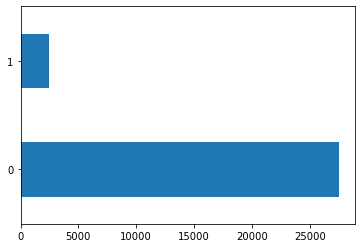

In [41]:
df_ValueCust.churn.value_counts().plot(kind='barh')

    * We have class Imbalance in our dataset since churn percent is only around 8%.
    * We will handle class imbalance through class_weight parameter or through SMOTE which is a oversampling technique

In [42]:
missing_percent,missing_features,missing_features_dict = missing_percent_calc(df_ValueCust)
print(f'There are total {len(missing_features_dict)} features with missing values')

There are total 111 features with missing values


In [43]:
print(missing_features_dict)

{'fb_user_8': 46.83, 'max_rech_data_8': 46.83, 'night_pck_user_8': 46.83, 'count_rech_2g_8': 46.83, 'arpu_2g_8': 46.83, 'count_rech_3g_8': 46.83, 'arpu_3g_8': 46.83, 'arpu_3g_6': 44.15, 'count_rech_2g_6': 44.15, 'count_rech_3g_6': 44.15, 'max_rech_data_6': 44.15, 'night_pck_user_6': 44.15, 'fb_user_6': 44.15, 'arpu_2g_6': 44.15, 'arpu_3g_7': 43.15, 'fb_user_7': 43.15, 'count_rech_3g_7': 43.15, 'arpu_2g_7': 43.15, 'count_rech_2g_7': 43.15, 'night_pck_user_7': 43.15, 'max_rech_data_7': 43.15, 'roam_og_mou_8': 3.91, 'og_others_8': 3.91, 'roam_ic_mou_8': 3.91, 'loc_ic_t2t_mou_8': 3.91, 'loc_ic_t2m_mou_8': 3.91, 'loc_ic_t2f_mou_8': 3.91, 'isd_og_mou_8': 3.91, 'spl_og_mou_8': 3.91, 'std_og_t2m_mou_8': 3.91, 'std_og_mou_8': 3.91, 'loc_og_t2t_mou_8': 3.91, 'std_og_t2c_mou_8': 3.91, 'std_og_t2f_mou_8': 3.91, 'loc_og_t2m_mou_8': 3.91, 'std_og_t2t_mou_8': 3.91, 'loc_og_mou_8': 3.91, 'loc_og_t2c_mou_8': 3.91, 'std_ic_t2t_mou_8': 3.91, 'loc_ic_mou_8': 3.91, 'loc_og_t2f_mou_8': 3.91, 'std_ic_mou_8':

In [44]:
# Extracting features which has only one unique value (apart from missing values)
single_Val_features = []
for i in df_ValueCust.columns:
    if df_ValueCust[i].nunique()==1:
        single_Val_features.append(i)
        print(f'{i} has {len(df_ValueCust[i].unique())} items which are {dict(df_ValueCust[i].value_counts())} & {dict(Nan=df_ValueCust[i].isnull().sum())}')

loc_og_t2o_mou has 2 items which are {0.0: 29777} & {'Nan': 224}
std_og_t2o_mou has 2 items which are {0.0: 29777} & {'Nan': 224}
loc_ic_t2o_mou has 2 items which are {0.0: 29777} & {'Nan': 224}
std_og_t2c_mou_6 has 2 items which are {0.0: 29456} & {'Nan': 545}
std_og_t2c_mou_7 has 2 items which are {0.0: 29464} & {'Nan': 537}
std_og_t2c_mou_8 has 2 items which are {0.0: 28827} & {'Nan': 1174}
std_ic_t2o_mou_6 has 2 items which are {0.0: 29456} & {'Nan': 545}
std_ic_t2o_mou_7 has 2 items which are {0.0: 29464} & {'Nan': 537}
std_ic_t2o_mou_8 has 2 items which are {0.0: 28827} & {'Nan': 1174}


    * It makes sense to drop above single_Val_features as they dont offer any variation in data.

In [45]:
df_ValueCust.drop(single_Val_features,axis=1,inplace=True) #Droping single Value features

In [46]:
missing_percent,missing_features,missing_features_dict=missing_percent_calc(df_ValueCust)
print(f'There are total {len(missing_features_dict)} features with missing values')

There are total 102 features with missing values


In [47]:
#Extracting features which has less than 5 unique values. Each value can be treated as a level.
#These features unlike single_val_features offer variation and can be treated as categorical variables since 
#few levels are present. 
NA_level_features = []
for i in df_ValueCust.columns:
    if (len(df_ValueCust[i].unique())<=4) and (i!='churn'):
        single_Val_features.append(i)
        NA_level_features.append(i)
        print(f'{i} has {len(df_ValueCust[i].unique())} items which are {dict(df_ValueCust[i].value_counts())} & {dict(Nan=df_ValueCust[i].isnull().sum())}')

night_pck_user_6 has 3 items which are {0.0: 16349, 1.0: 407} & {'Nan': 13245}
night_pck_user_7 has 3 items which are {0.0: 16682, 1.0: 375} & {'Nan': 12944}
night_pck_user_8 has 3 items which are {0.0: 15612, 1.0: 341} & {'Nan': 14048}
fb_user_6 has 3 items which are {1.0: 15525, 0.0: 1231} & {'Nan': 13245}
fb_user_7 has 3 items which are {1.0: 15722, 0.0: 1335} & {'Nan': 12944}
fb_user_8 has 3 items which are {1.0: 14313, 0.0: 1640} & {'Nan': 14048}


In [48]:
# Converting above features to categorical and Imputing missing values with 'N/A' level.
for i in NA_level_features:
    df_ValueCust[i]=df_ValueCust[i].apply(lambda x:'N/A' if pd.isnull(x) else str(x))

In [49]:
print(f'There are total {len(missing_features_dict)} features with missing values')

There are total 102 features with missing values


In [50]:
missing_percent,missing_features,missing_features_dict=missing_percent_calc(df_ValueCust)
print(missing_features_dict)

{'arpu_2g_8': 46.83, 'arpu_3g_8': 46.83, 'max_rech_data_8': 46.83, 'count_rech_2g_8': 46.83, 'count_rech_3g_8': 46.83, 'count_rech_3g_6': 44.15, 'max_rech_data_6': 44.15, 'count_rech_2g_6': 44.15, 'arpu_3g_6': 44.15, 'arpu_2g_6': 44.15, 'count_rech_3g_7': 43.15, 'count_rech_2g_7': 43.15, 'arpu_3g_7': 43.15, 'max_rech_data_7': 43.15, 'arpu_2g_7': 43.15, 'std_og_t2t_mou_8': 3.91, 'loc_ic_t2m_mou_8': 3.91, 'loc_ic_t2t_mou_8': 3.91, 'spl_og_mou_8': 3.91, 'isd_og_mou_8': 3.91, 'std_og_mou_8': 3.91, 'std_og_t2f_mou_8': 3.91, 'std_og_t2m_mou_8': 3.91, 'roam_ic_mou_8': 3.91, 'loc_og_mou_8': 3.91, 'loc_og_t2c_mou_8': 3.91, 'loc_og_t2f_mou_8': 3.91, 'loc_og_t2m_mou_8': 3.91, 'loc_og_t2t_mou_8': 3.91, 'roam_og_mou_8': 3.91, 'loc_ic_mou_8': 3.91, 'offnet_mou_8': 3.91, 'onnet_mou_8': 3.91, 'loc_ic_t2f_mou_8': 3.91, 'og_others_8': 3.91, 'std_ic_t2f_mou_8': 3.91, 'std_ic_t2m_mou_8': 3.91, 'ic_others_8': 3.91, 'std_ic_t2t_mou_8': 3.91, 'std_ic_mou_8': 3.91, 'isd_ic_mou_8': 3.91, 'spl_ic_mou_8': 3.91, 

In [51]:
# Features with missing value between 30 and 50%
impute_zero_features = missing_features[missing_features.between(30, 50, inclusive=True)].index
df_ValueCust[impute_zero_features].describe()

arpu_2g_8     arpu_3g_8  max_rech_data_8  count_rech_2g_8  \
count  15953.000000  15953.000000     15953.000000     15953.000000   
mean     109.817427    118.050972       136.329217         2.272676   
std      195.348610    218.941369       119.531924         3.112685   
min      -24.430000    -24.490000         1.000000         0.000000   
25%        0.000000      0.000000        25.000000         0.000000   
50%       19.900000     10.020000       152.000000         1.000000   
75%      157.190000    179.490000       198.000000         3.000000   
max     3467.170000   3716.900000      1555.000000        44.000000   

       count_rech_3g_8  count_rech_3g_6  max_rech_data_6  count_rech_2g_6  \
count     15953.000000     16756.000000     16756.000000     16756.000000   
mean          0.777471         0.764801       139.798580         2.221175   
std           1.667737         1.477739       118.851784         3.005300   
min           0.000000         0.000000         1.000000         0.000000   
25%           0.000000         0.000000        25.000000         0.000000   
50%           0.000000         0.000000       152.000000         1.000000   
75%           1.000000         1.000000       198.000000         3.000000   
max          45.000000        29.000000      1555.000000        42.000000   

          arpu_3g_6     arpu_2g_6  count_rech_3g_7  count_rech_2g_7  \
count  16756.000000  16756.000000     17057.000000     17057.000000   
mean     119.974696    113.585859         0.802955         2.457642   
std      226.092738    201.792701         1.617808         3.235315   
min      -30.280000    -15.320000         0.000000         0.000000   
25%        0.000000      0.010000         0.000000         0.000000   
50%       15.480000     26.915000         0.000000         1.000000   
75%      177.787500    168.517500         1.000000         3.000000   
max     6362.280000   6433.760000        35.000000        48.000000   

          arpu_3g_7  max_rech_data_7     arpu_2g_7  
count  17057.000000     17057.000000  17057.000000  
mean     120.695809       140.431143    113.801227  
std      229.575385       120.247247    206.066861  
min      -26.040000         1.000000    -15.480000  
25%        0.000000        25.000000      0.000000  
50%       12.950000       152.000000     24.000000  
75%      180.040000       198.000000    166.910000  
max     4980.900000      1555.000000   4809.360000

    * For above features it looks like missing value indicates absence of value rather 
    than invalid value e.g., Missing value in count_rech_3g_8 indicates customer has 
    made 0 number of 3g recharges in month of august.

In [52]:
# Imputing missing value with 0 for above features.
for feature in impute_zero_features:
    df_ValueCust[feature] = df_ValueCust[feature].apply(lambda x:0 if pd.isnull(x)
                                                        else x)

In [53]:
missing_percent,missing_features,missing_features_dict=missing_percent_calc(df_ValueCust) 
print(f'There are total {len(missing_features_dict)} features with missing values')

There are total 81 features with missing values


In [54]:
print(missing_features_dict)

{'ic_others_8': 3.91, 'loc_og_t2m_mou_8': 3.91, 'std_og_mou_8': 3.91, 'spl_og_mou_8': 3.91, 'std_og_t2f_mou_8': 3.91, 'og_others_8': 3.91, 'std_og_t2m_mou_8': 3.91, 'loc_ic_t2t_mou_8': 3.91, 'std_og_t2t_mou_8': 3.91, 'loc_ic_t2m_mou_8': 3.91, 'loc_og_mou_8': 3.91, 'loc_ic_t2f_mou_8': 3.91, 'loc_og_t2c_mou_8': 3.91, 'loc_ic_mou_8': 3.91, 'std_ic_t2t_mou_8': 3.91, 'loc_og_t2f_mou_8': 3.91, 'isd_og_mou_8': 3.91, 'loc_og_t2t_mou_8': 3.91, 'onnet_mou_8': 3.91, 'isd_ic_mou_8': 3.91, 'std_ic_t2f_mou_8': 3.91, 'roam_og_mou_8': 3.91, 'offnet_mou_8': 3.91, 'std_ic_mou_8': 3.91, 'std_ic_t2m_mou_8': 3.91, 'roam_ic_mou_8': 3.91, 'spl_ic_mou_8': 3.91, 'std_og_t2m_mou_6': 1.82, 'std_og_mou_6': 1.82, 'offnet_mou_6': 1.82, 'std_og_t2f_mou_6': 1.82, 'loc_og_t2m_mou_6': 1.82, 'roam_ic_mou_6': 1.82, 'roam_og_mou_6': 1.82, 'loc_og_mou_6': 1.82, 'loc_og_t2c_mou_6': 1.82, 'loc_og_t2t_mou_6': 1.82, 'isd_og_mou_6': 1.82, 'loc_og_t2f_mou_6': 1.82, 'std_og_t2t_mou_6': 1.82, 'onnet_mou_6': 1.82, 'spl_ic_mou_6': 1

In [55]:
# Remaining features with missing values:
df_ValueCust[missing_features.index].describe()

ic_others_8  loc_og_t2m_mou_8  std_og_mou_8  spl_og_mou_8  \
count  28827.000000      28827.000000  28827.000000  28827.000000   
mean       1.274322        157.937216    319.897555      6.824251   
std       13.038515        236.315181    618.022200     20.677329   
min        0.000000          0.000000      0.000000      0.000000   
25%        0.000000         17.530000      0.000000      0.000000   
50%        0.000000         74.540000     32.680000      0.660000   
75%        0.060000        205.860000    383.320000      6.540000   
max     1209.860000       4961.330000  13980.060000    954.510000   

       std_og_t2f_mou_8   og_others_8  std_og_t2m_mou_8  loc_ic_t2t_mou_8  \
count      28827.000000  28827.000000      28827.000000      28827.000000   
mean           1.649273      0.059953        163.758261         65.169653   
std           11.147419      3.381939        416.088724        161.602601   
min            0.000000      0.000000          0.000000          0.000000   
25%            0.000000      0.000000          0.000000          6.380000   
50%            0.000000      0.000000         12.260000         24.760000   
75%            0.000000      0.000000        128.135000         67.690000   
max          516.910000    394.930000      13950.040000       4003.210000   

       std_og_t2t_mou_8  loc_ic_t2m_mou_8  loc_og_mou_8  loc_ic_t2f_mou_8  \
count      28827.000000      28827.000000  28827.000000      28827.000000   
mean         154.486547        152.188163    245.328371         14.989754   
std          404.426554        217.137562    367.505268         44.078609   
min            0.000000          0.000000      0.000000          0.000000   
25%            0.000000         29.540000     29.635000          0.000000   
50%            1.430000         85.790000    120.860000          2.010000   
75%           88.235000        191.780000    321.935000         12.010000   
max         8014.430000       4643.490000  11039.910000       1588.530000   

       loc_og_t2c_mou_8  loc_ic_mou_8  std_ic_t2t_mou_8  loc_og_t2f_mou_8  \
count      28827.000000  28827.000000      28827.000000      28827.000000   
mean           1.777295    232.357291         14.480350          6.126112   
std            7.345047    311.154100         72.720335         19.858510   
min            0.000000      0.000000          0.000000          0.000000   
25%            0.000000     48.660000          0.000000          0.000000   
50%            0.000000    137.590000          0.280000          0.000000   
75%            0.110000    295.235000          7.645000          4.260000   
max          351.830000   5388.740000       4309.290000        928.490000   

       isd_og_mou_8  loc_og_t2t_mou_8   onnet_mou_8  isd_ic_mou_8  \
count  28827.000000      28827.000000  28827.000000  28827.000000   
mean       2.028343         81.256858    243.646938     11.446169   
std       45.611669        231.399901    465.200856     71.988368   
min        0.000000          0.000000      0.000000      0.000000   
25%        0.000000          3.830000     14.255000      0.000000   
50%        0.000000         23.240000     72.930000      0.000000   
75%        0.000000         76.040000    255.025000      0.000000   
max     5681.540000      10752.560000  10752.560000   3432.880000   

       std_ic_t2f_mou_8  roam_og_mou_8  offnet_mou_8  std_ic_mou_8  \
count      28827.000000   28827.000000  28827.000000  28827.000000   
mean           2.666308      20.674656    348.723294     46.209942   
std           20.291213     106.751862    486.918550    141.316476   
min            0.000000       0.000000      0.000000      0.000000   
25%            0.000000       0.000000     58.670000      0.850000   
50%            0.000000       0.000000    197.590000     10.540000   
75%            0.200000       0.000000    455.385000     40.440000   
max         1394.890000    5337.040000  14007.340000   5957.140000   

       std_ic_t2m_mou_8  roam_ic_mou_8  spl_ic_mou_

    * Imputing missing values with median for above features

In [56]:
median_impute_features = missing_features.index
for feature in median_impute_features:
    df_ValueCust[feature] = df_ValueCust[feature].apply(lambda x:df_ValueCust[feature].median() if pd.isnull(x)
                                                        else x)

In [57]:
missing_percent,missing_features,missing_features_dict=missing_percent_calc(df_ValueCust) 
print(f'There are now total {len(missing_features_dict)} features with missing values')

There are now total 0 features with missing values


### Feature engineering 
* Deriving features representing difference between action phase and good phase 
* i.e. difference_feature = feature_8 - [avg(feature_6,feature_7)] 
* to avoid multicollinearity we will drop 8 month numeric features.
* Since there are lot of features, to avoid manual typing we will take following approach:
    * we will create a new dataframe y_df containg difference_feature values then we will superimpose it on original dataframe.

In [58]:
a_df = df_ValueCust.filter(regex='^(?!night_pck_user|fb_user).*_6$')
a_df.head(2)

arpu_6  onnet_mou_6  offnet_mou_6  roam_ic_mou_6  roam_og_mou_6  \
0   197.385        88.06       229.635           0.00           0.00   
7  1069.180        57.84       453.430          16.23          23.74   

   loc_og_t2t_mou_6  loc_og_t2m_mou_6  loc_og_t2f_mou_6  loc_og_t2c_mou_6  \
0             25.58             80.24              0.11               0.0   
7             51.39            308.63             62.13               0.0   

   loc_og_mou_6  std_og_t2t_mou_6  std_og_t2m_mou_6  std_og_t2f_mou_6  \
0        129.35              3.36            18.185              0.00   
7        422.16              4.30            49.890              6.66   

   std_og_mou_6  isd_og_mou_6  spl_og_mou_6  og_others_6  total_og_mou_6  \
0        50.795           0.0          0.31          0.0            0.00   
7        60.860           0.0          4.50          0.0          487.53   

   loc_ic_t2t_mou_6  loc_ic_t2m_mou_6  loc_ic_t2f_mou_6  loc_ic_mou_6  \
0             26.03             86.76              2.01        138.63   
7             58.14            217.56            152.16        427.88   

   std_ic_t2t_mou_6  std_ic_t2m_mou_6  std_ic_t2f_mou_6  std_ic_mou_6  \
0              0.48              5.34              0.00         11.98   
7             36.89             91.44             52.19        180.54   

   total_ic_mou_6  spl_ic_mou_6  isd_ic_mou_6  ic_others_6  total_rech_num_6  \
0            0.00          0.00          0.00         0.00                 4   
7          626.46          0.21          2.06        15.74                 5   

   max_rech_amt_6  last_day_rch_amt_6  max_rech_data_6  count_rech_2g_6  \
0             252                 252            252.0              0.0   
7            1580                   0              0.0              0.0   

   count_rech_3g_6  vol_2g_mb_6  vol_3g_mb_6  arpu_3g_6  arpu_2g_6  \
0              1.0        30.13        83.57     212.17     212.17   
7              0.0         0.00         0.00       0.00       0.00   

   monthly_2g_6  sachet_2g_6  monthly_3g_6  sachet_3g_6  
0             0            0             1            0  
7             0            0             0            0

In [59]:
b_df = df_ValueCust.filter(regex='^(?!night_pck_user|fb_user).*_7$')
b_df.head(2)

arpu_7  onnet_mou_7  offnet_mou_7  roam_ic_mou_7  roam_og_mou_7  \
0   214.816       86.885        227.12           0.00           0.00   
7  1349.850       54.680        567.16          33.49          12.59   

   loc_og_t2t_mou_7  loc_og_t2m_mou_7  loc_og_t2f_mou_7  loc_og_t2c_mou_7  \
0             25.78            81.685              0.21               0.0   
7             31.38           447.380             55.14               0.0   

   loc_og_mou_7  std_og_t2t_mou_7  std_og_t2m_mou_7  std_og_t2f_mou_7  \
0        132.73              3.30             17.75              0.00   
7        533.91             23.29             31.76             20.08   

   std_og_mou_7  isd_og_mou_7  spl_og_mou_7  og_others_7  total_og_mou_7  \
0        50.035          0.00          0.81          0.0            0.00   
7        75.140          0.18          0.00          0.0          609.24   

   loc_ic_t2t_mou_7  loc_ic_t2m_mou_7  loc_ic_t2f_mou_7  loc_ic_mou_7  \
0             26.66             88.37              2.16        141.79   
7             32.26            221.49            101.46        355.23   

   std_ic_t2t_mou_7  std_ic_t2m_mou_7  std_ic_t2f_mou_7  std_ic_mou_7  \
0              0.55              5.54              0.00         12.74   
7             11.83            126.99             34.24        173.08   

   total_ic_mou_7  spl_ic_mou_7  isd_ic_mou_7  ic_others_7  total_rech_num_7  \
0            0.00           0.0          0.00         0.00                 3   
7          558.04           0.0         14.53        15.19                 5   

   max_rech_amt_7  last_day_rch_amt_7  max_rech_data_7  count_rech_2g_7  \
0             252                 252            252.0              0.0   
7             790                   0              0.0              0.0   

   count_rech_3g_7  vol_2g_mb_7  vol_3g_mb_7  arpu_3g_7  arpu_2g_7  \
0              1.0         1.32       150.76     212.17     212.17   
7              0.0         0.00         0.00       0.00       0.00   

   monthly_2g_7  sachet_2g_7  monthly_3g_7  sachet_3g_7  
0             0            0             1            0  
7             0            0             0            0

In [60]:
c_df = df_ValueCust.filter(regex='^(?!night_pck_user|fb_user).*_8$')
c_df.head(2)

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0   213.803         0.00          0.00           0.00           0.00   
7  3171.480        52.29        325.91          31.64          38.06   

   loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00               0.0   
7             40.28            162.28             53.23               0.0   

   loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
0          0.00              0.00              0.00              0.00   
7        255.79             12.01             49.14             16.68   

   std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
0          0.00          0.00           0.0          0.0            0.00   
7         77.84         10.01           6.5          0.0          350.16   

   loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
0              0.16              4.13              1.15          5.44   
7             27.31            121.19             39.53        188.04   

   std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
0              0.00              0.00              0.00          0.00   
7             30.39            141.33             22.21        193.94   

   total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0            5.44           0.0          0.00         0.00                 2   
7          428.74           0.0         31.59        15.14                 7   

   max_rech_amt_8  last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
0             252                 252            252.0              0.0   
7            1580                 779              0.0              0.0   

   count_rech_3g_8  vol_2g_mb_8  vol_3g_mb_8  arpu_3g_8  arpu_2g_8  \
0              1.0         5.75       109.61     212.17     212.17   
7              0.0         0.00         0.00       0.00       0.00   

   monthly_2g_8  sachet_2g_8  monthly_3g_8  sachet_3g_8  
0             0            0             1            0  
7             0            0             0            0

In [61]:
x_df = (a_df + b_df.values)/2
y_df = c_df - x_df.values

In [62]:
y_df.head(2)

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0     7.7025     -87.4725     -228.3775           0.00          0.000   
7  1961.9650      -3.9700     -184.3850           6.78         19.895   

   loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0           -25.680          -80.9625            -0.160               0.0   
7            -1.105         -215.7250            -5.405               0.0   

   loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
0      -131.040            -3.330          -17.9675              0.00   
7      -222.245            -1.785            8.3150              3.31   

   std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
0       -50.415          0.00         -0.56          0.0           0.000   
7         9.840          9.92          4.25          0.0        -198.225   

   loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
0           -26.185           -83.435            -0.935      -134.770   
7           -17.890           -98.335           -87.280      -203.515   

   std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
0            -0.515            -5.440             0.000        -12.36   
7             6.030            32.115           -21.005         17.13   

   total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0            5.44         0.000         0.000        0.000              -1.5   
7         -163.51        -0.105        23.295       -0.325               2.0   

   max_rech_amt_8  last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
0             0.0                 0.0              0.0              0.0   
7           395.0               779.0              0.0              0.0   

   count_rech_3g_8  vol_2g_mb_8  vol_3g_mb_8  arpu_3g_8  arpu_2g_8  \
0              0.0       -9.975       -7.555        0.0        0.0   
7              0.0        0.000        0.000        0.0        0.0   

   monthly_2g_8  sachet_2g_8  monthly_3g_8  sachet_3g_8  
0           0.0          0.0           0.0          0.0  
7           0.0          0.0           0.0          0.0

* Since there are lot of features, to avoid manual typing we will take following approach:
    * We will first drop numeric 8 month features.
    * Then we will rename respective y_df columns 
    * THen we will join y_df to df_ValueCust.

In [63]:
col_name_edit = y_df.columns               #extracting columns which need to be renamed.
df_ValueCust.drop(col_name_edit,axis=1,inplace=True)   # dropping columns which needs to be renamed.
y_df = y_df.rename(columns = lambda x: str(x)[:-1]+'diff(action-good)')            # renaming columns.
df_ValueCust=df_ValueCust.join(y_df)                               #Adding renamed columns to OG dataframe.

In [64]:
print(f'Total number of predictors = {df_ValueCust.shape[1]-1}')

Total number of predictors = 145


## EDA and data visualization

In [65]:
Continous_features = df_ValueCust.select_dtypes(exclude='object').columns
categorical_features = df_ValueCust.select_dtypes('object').columns

In [66]:
df_ValueCust[Continous_features].describe()

arpu_6        arpu_7   onnet_mou_6   onnet_mou_7  offnet_mou_6  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean     558.490824    560.782203    262.392728    269.374484    377.865524   
std      460.640461    479.776947    458.886532    479.263904    480.262085   
min    -2258.709000  -2014.045000      0.000000      0.000000      0.000000   
25%      309.865000    309.826000     20.010000     18.930000     80.710000   
50%      481.694000    480.943000     88.060000     86.885000    229.635000   
75%      699.943000    698.315000    290.440000    290.240000    487.940000   
max    27731.088000  35145.834000   7376.710000   8157.780000   8362.360000   

       offnet_mou_7  roam_ic_mou_6  roam_ic_mou_7  roam_og_mou_6  \
count  30001.000000   30001.000000   30001.000000   30001.000000   
mean     382.168481      16.110355      12.642504      26.571547   
std      496.746629      76.302156      75.785903     116.205525   
min        0.000000       0.000000       0.000000       0.000000   
25%       78.540000       0.000000       0.000000       0.000000   
50%      227.120000       0.000000       0.000000       0.000000   
75%      494.010000       0.000000       0.000000       0.000000   
max     9667.130000    2613.310000    3813.290000    3775.110000   

       roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2m_mou_6  \
count   30001.000000      30001.000000      30001.000000      30001.000000   
mean       20.152086         84.949441         86.135734        164.700941   
std        96.100428        228.647866        240.385875        249.393839   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          5.240000          5.530000         21.840000   
50%         0.000000         25.580000         25.780000         80.240000   
75%         0.000000         77.980000         78.340000        208.930000   
max      2812.040000       6431.330000       7400.660000       4729.740000   

       loc_og_t2m_mou_7  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2c_mou_6  \
count      30001.000000      30001.000000      30001.000000      30001.000000   
mean         164.472076          6.346113          6.427442          1.575104   
std          240.831704         22.122993         21.943100          6.303385   
min            0.000000          0.000000          0.000000          0.000000   
25%           23.680000          0.000000          0.000000          0.000000   
50%           81.685000          0.110000          0.210000          0.000000   
75%          208.410000          4.230000          4.380000          0.000000   
max         4557.140000       1466.030000       1196.430000        271.440000   

       loc_og_t2c_mou_7  loc_og_mou_6  loc_og_mou_7  std_og_t2t_mou_6  \
count      30001.000000  30001.000000  30001.000000      30001.000000   
mean           1.889875    256.430168    257.492080        165.946334   
std            9.158984    377.153512    374.215004        403.807140   
min            0.000000      0.000000      0.000000          0.000000   
25%            0.000000     36.980000     38.930000          0.000000   
50%            0.000000    129.350000    132.730000          3.360000   
75%            0.100000    332.090000    333.390000        109.610000   
max          569.710000  10643.380000   7674.780000       7366.580000   

       std_og_t2t_mou_7  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2f_mou_6  \
count      30001.000000      30001.000000      30001.000000      30001.000000   
mean         174.293040        179.763738        188.238482          1.803548   
std          421.165968        408.888077        433.500819         11.979429   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            3.300000         18.185000         17.750000          0.000000   
75%          116.610000       

In [67]:
# # Code commented to reduce runtime
# for feature in Continous_features:
#     sns.distplot(df_ValueCust[feature])
#     plt.show()

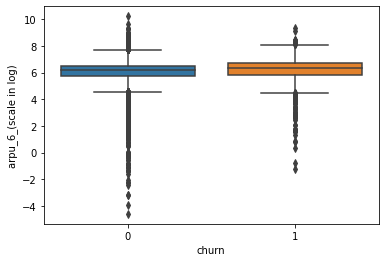

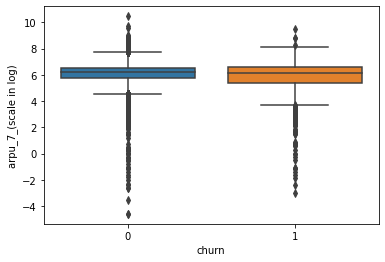

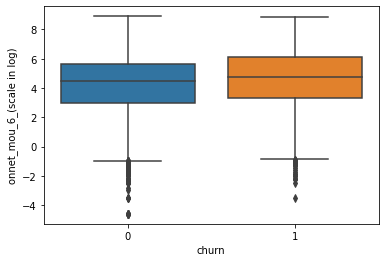

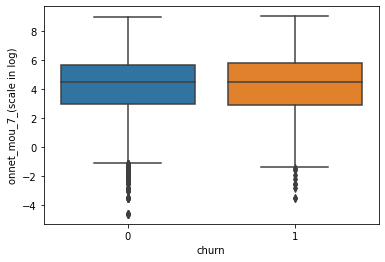

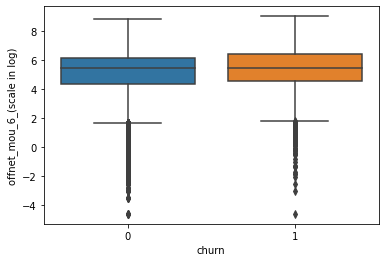

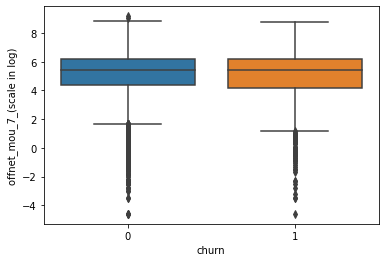

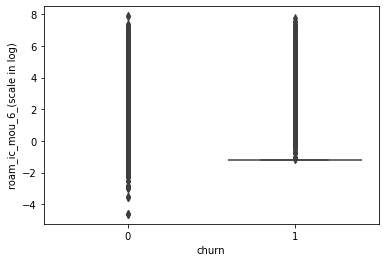

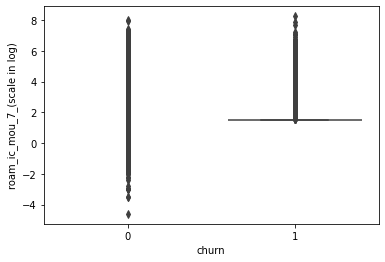

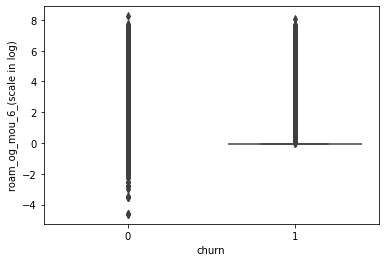

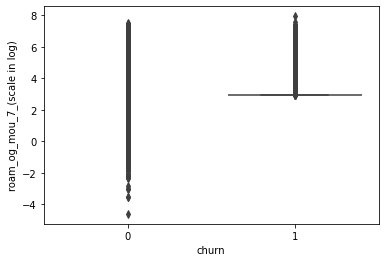

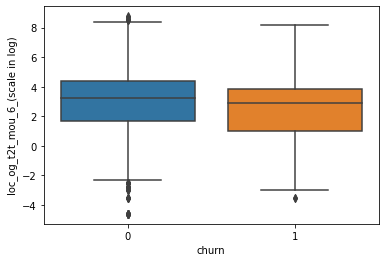

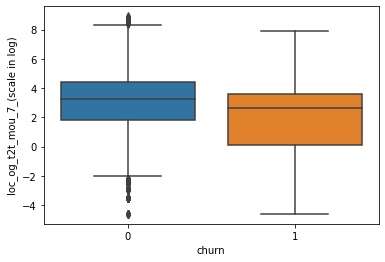

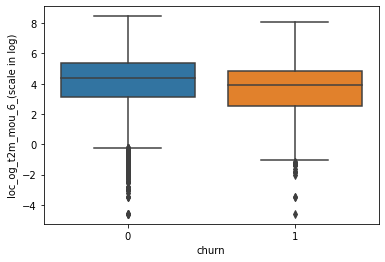

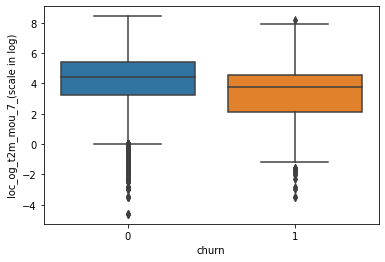

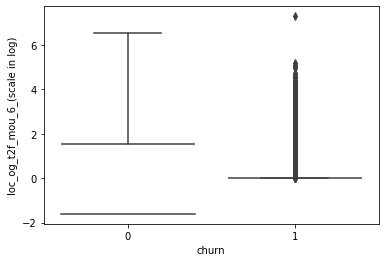

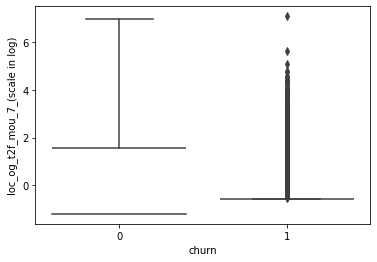

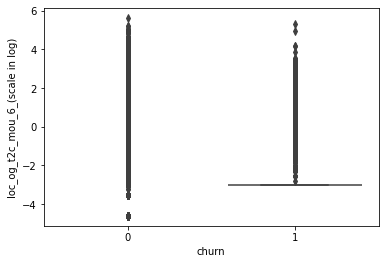

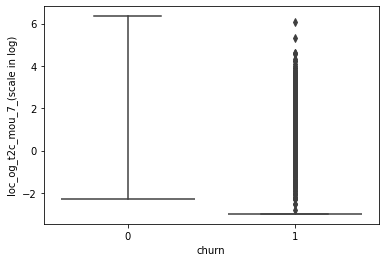

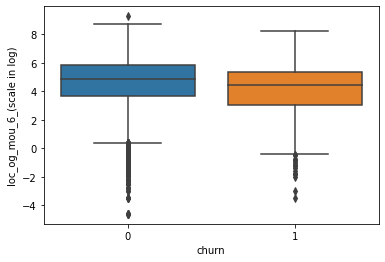

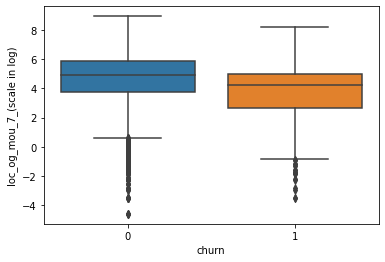

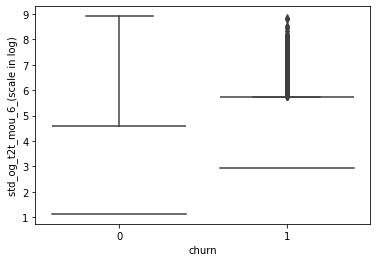

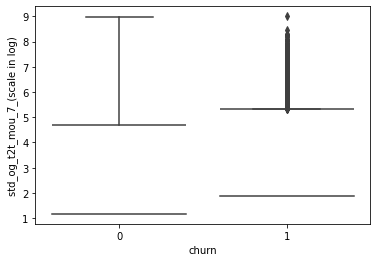

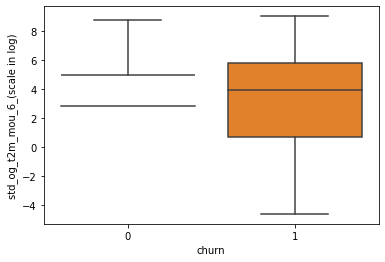

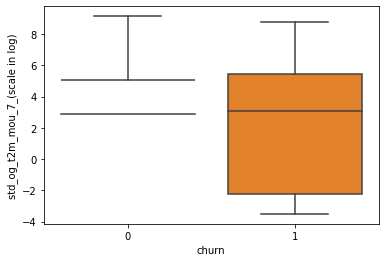

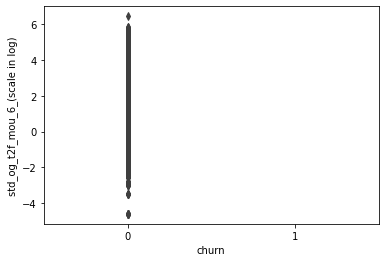

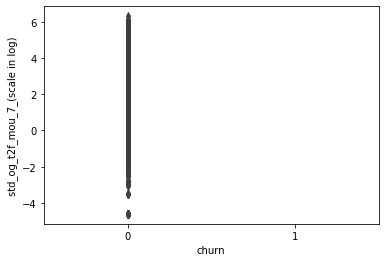

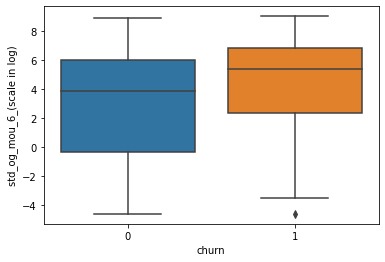

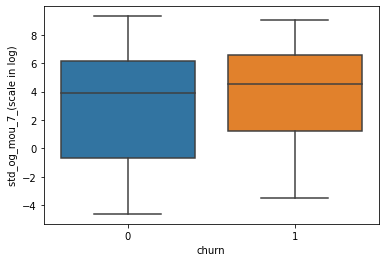

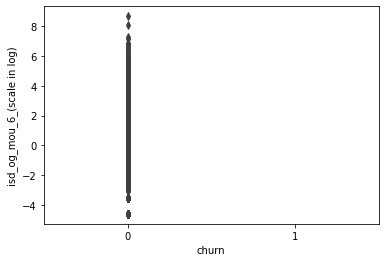

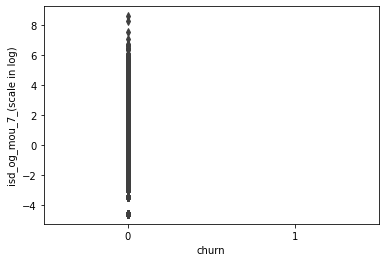

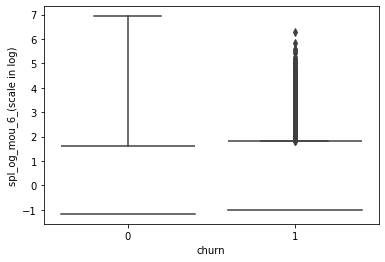

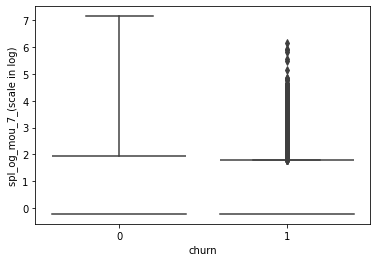

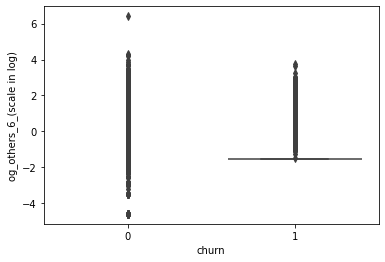

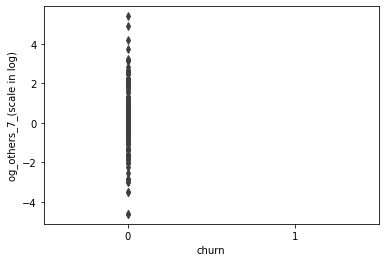

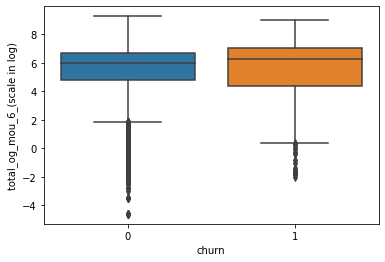

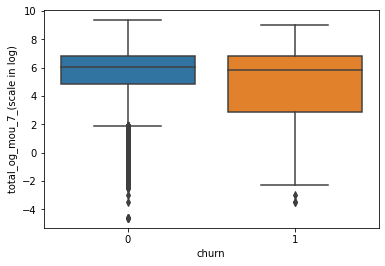

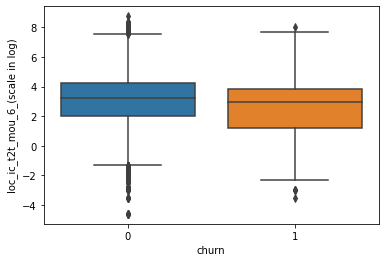

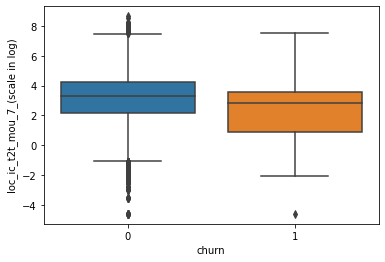

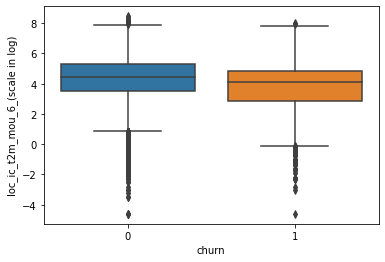

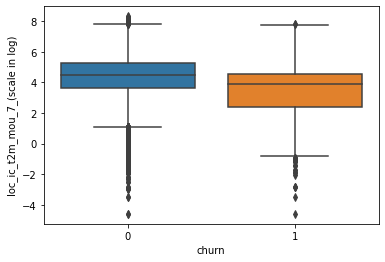

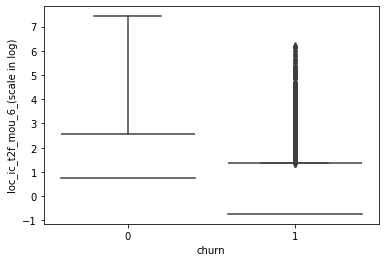

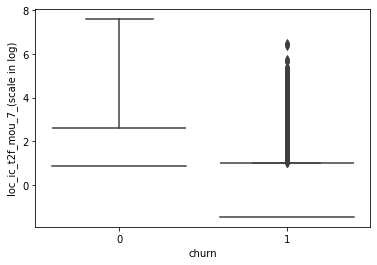

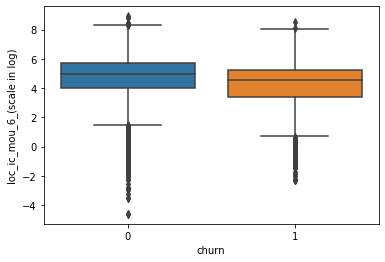

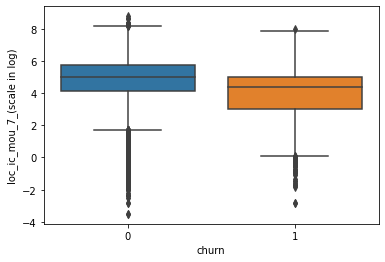

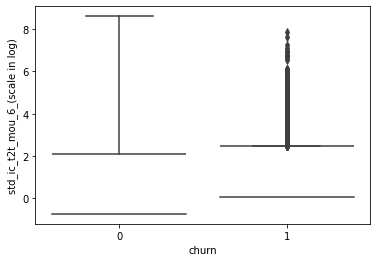

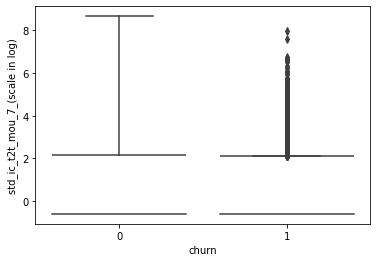

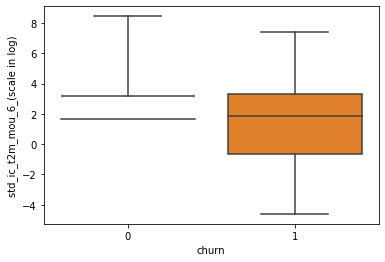

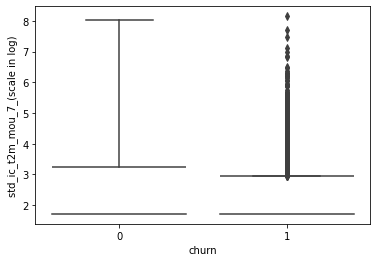

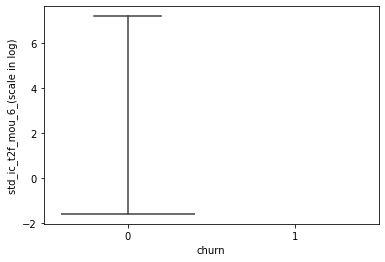

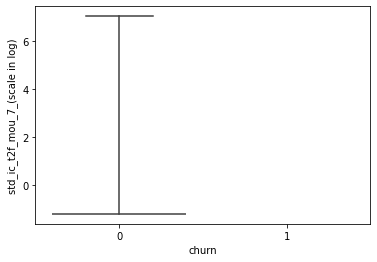

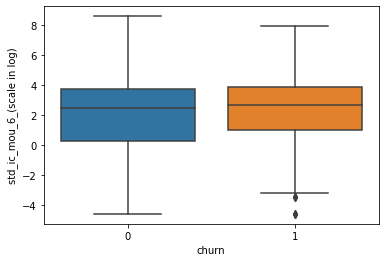

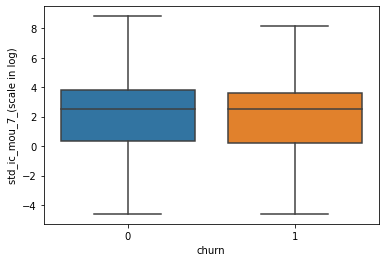

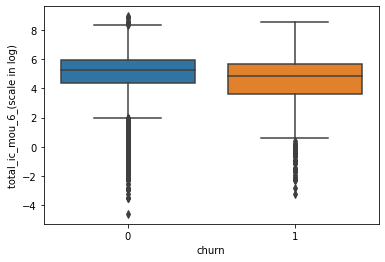

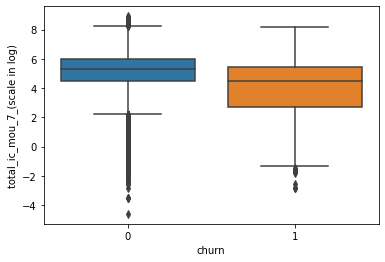

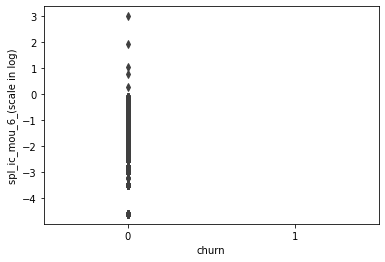

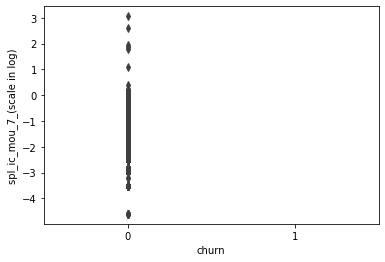

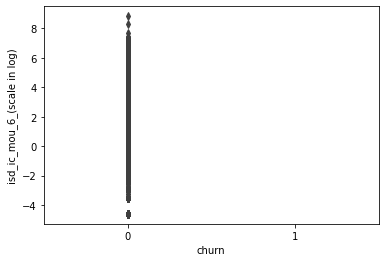

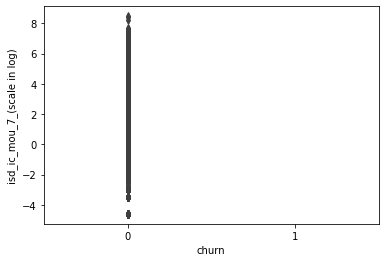

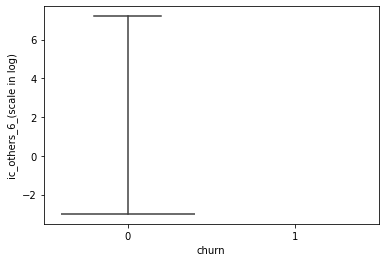

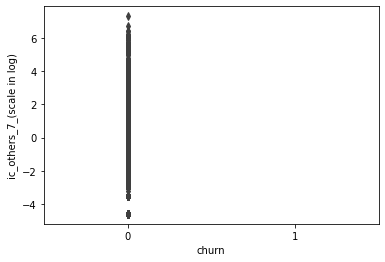

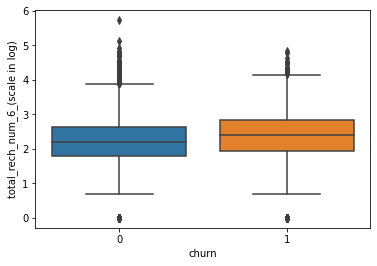

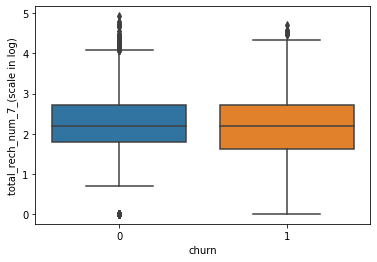

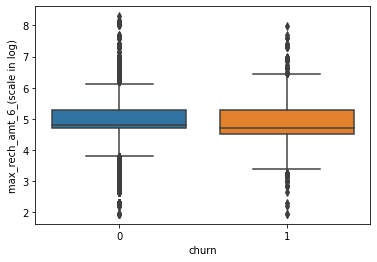

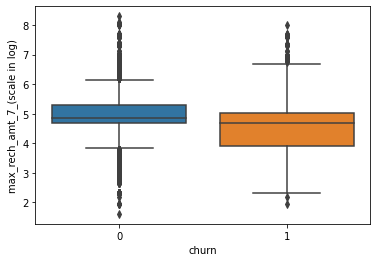

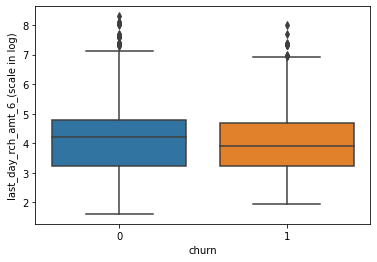

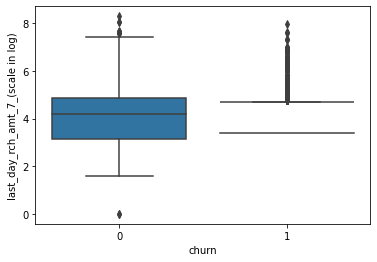

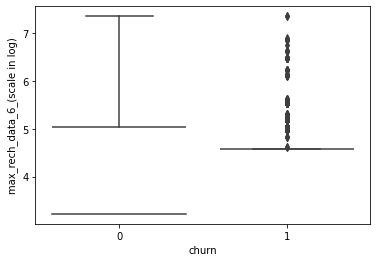

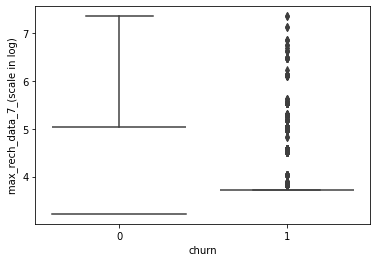

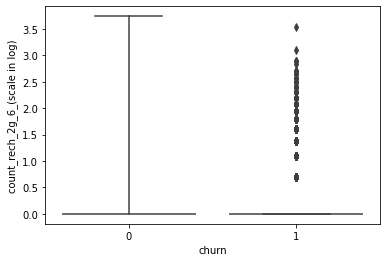

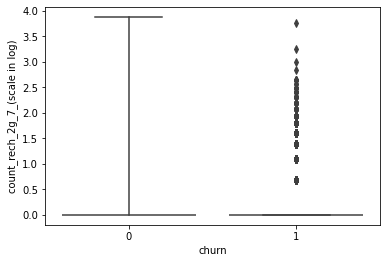

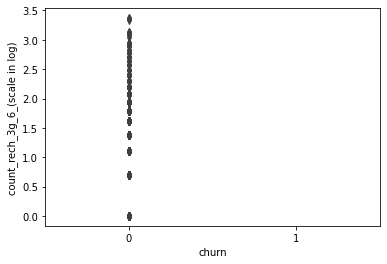

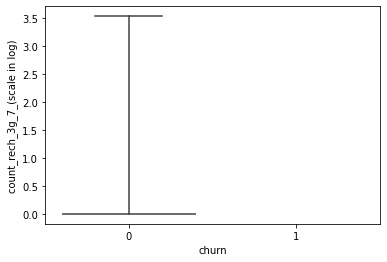

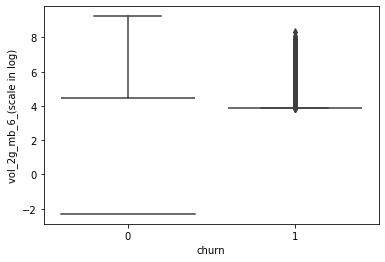

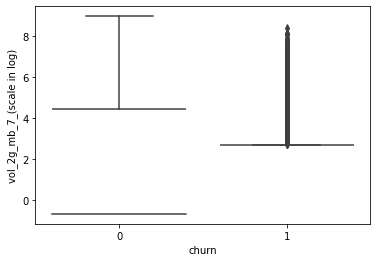

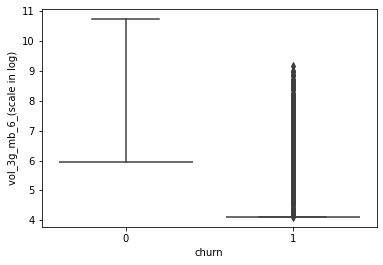

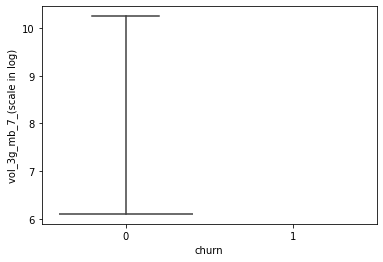

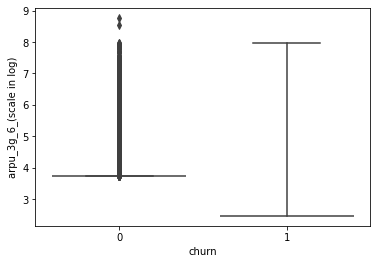

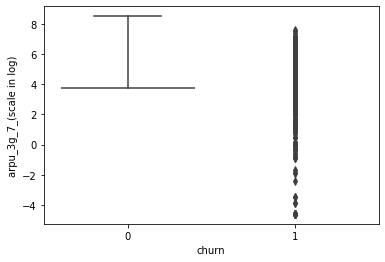

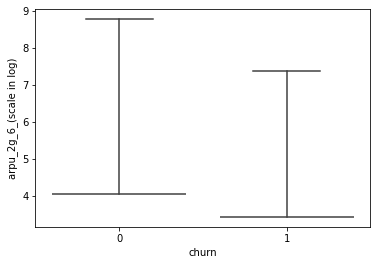

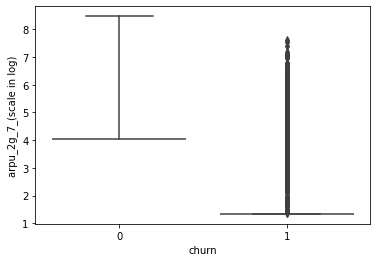

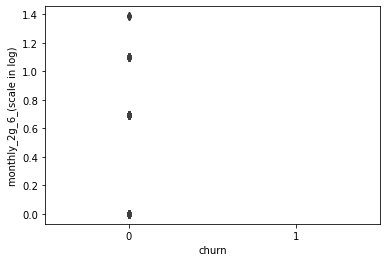

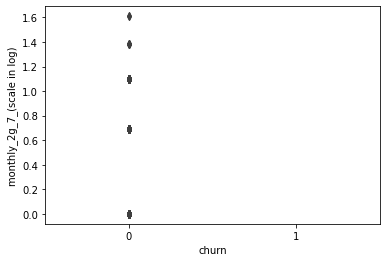

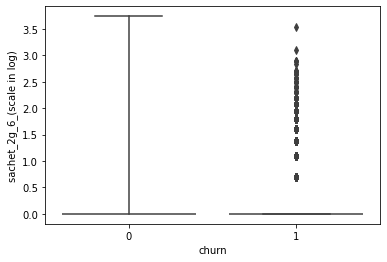

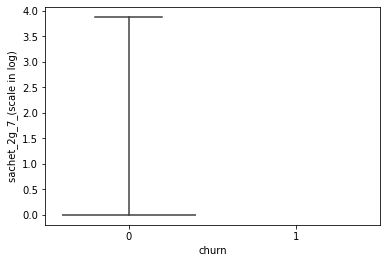

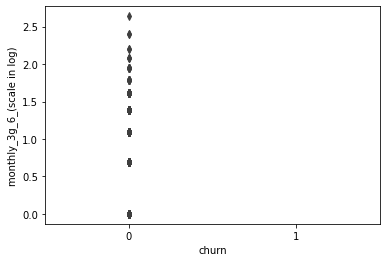

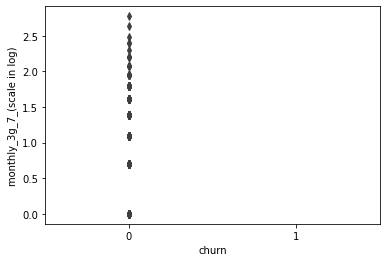

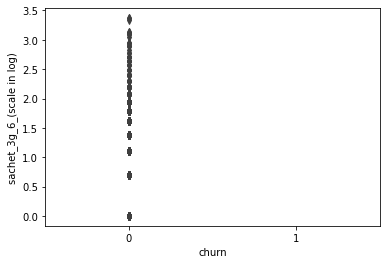

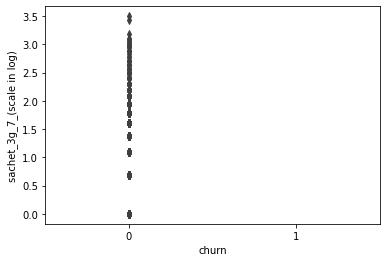

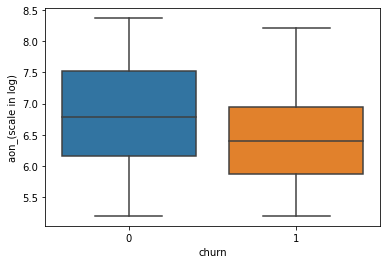

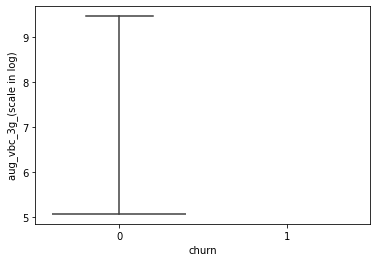

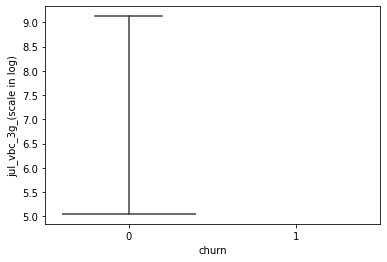

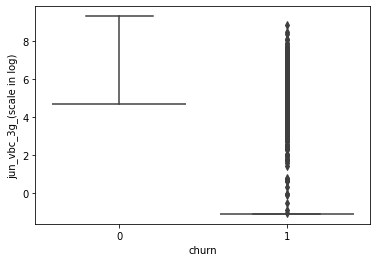

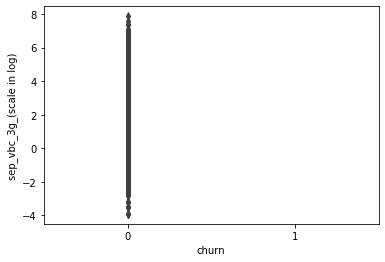

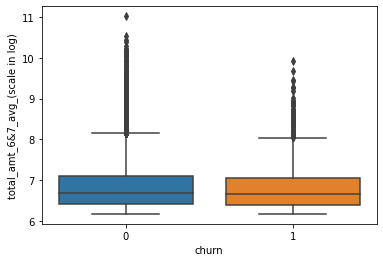

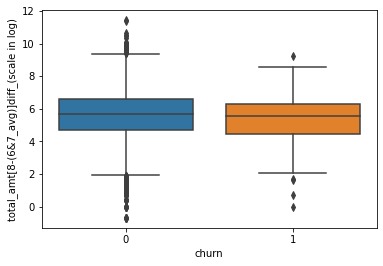

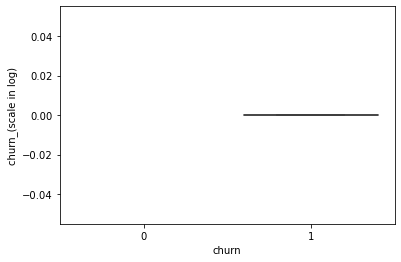

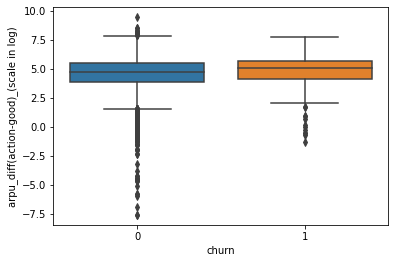

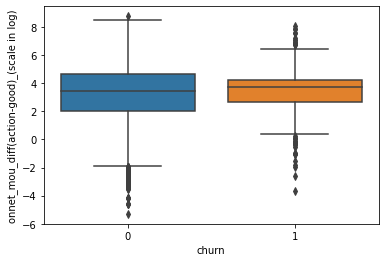

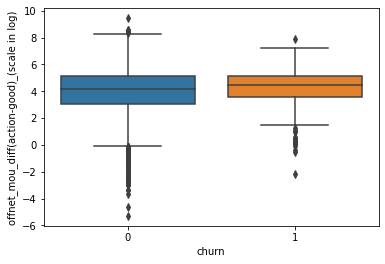

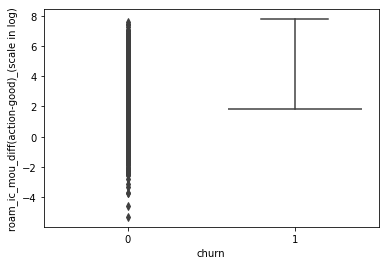

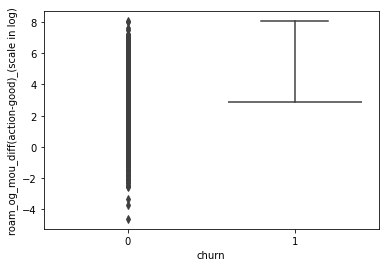

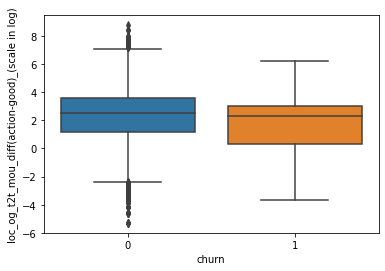

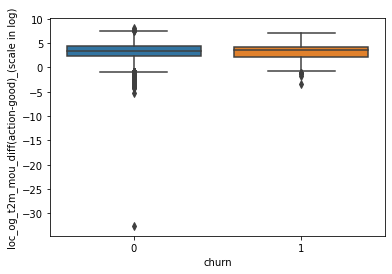

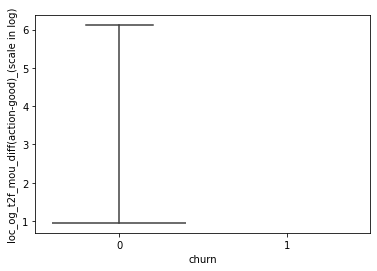

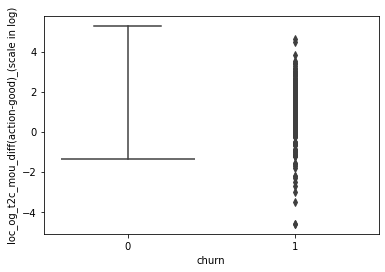

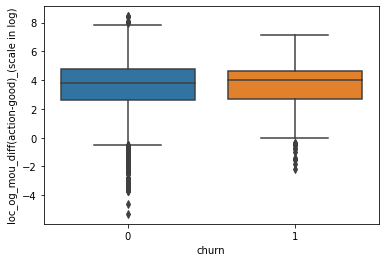

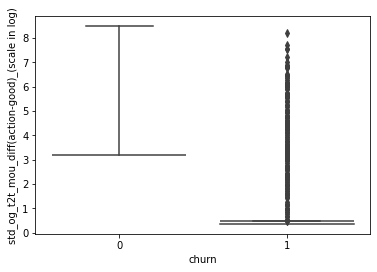

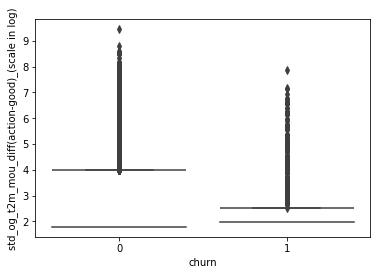

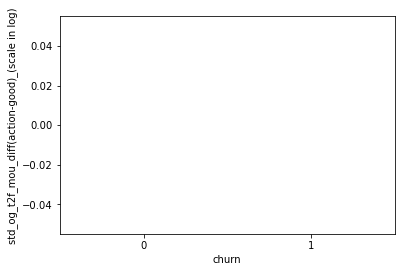

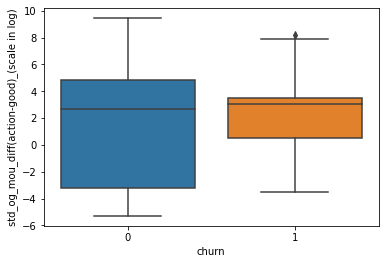

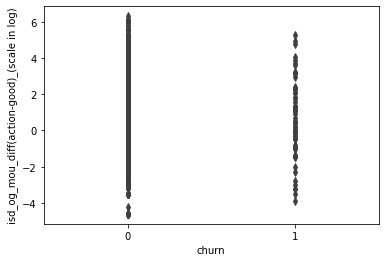

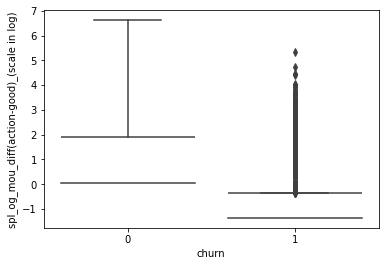

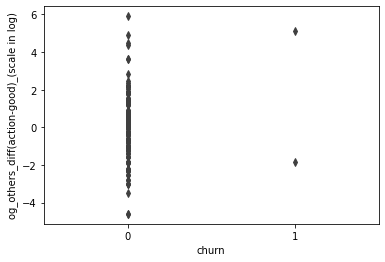

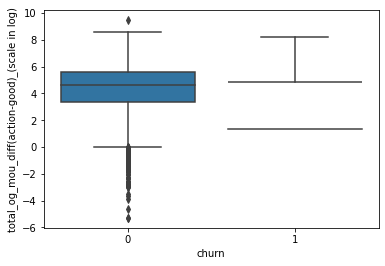

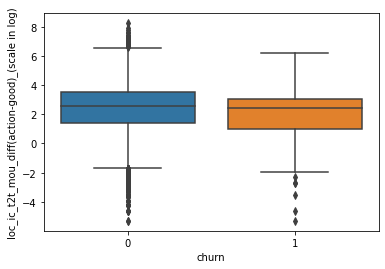

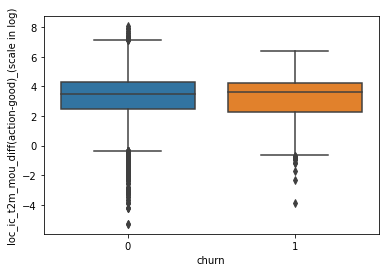

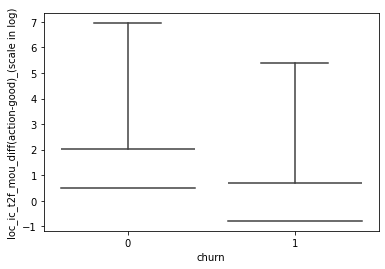

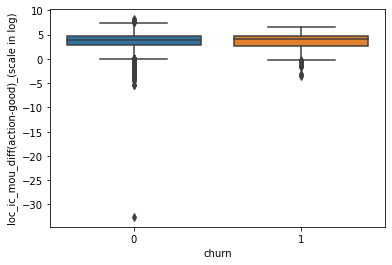

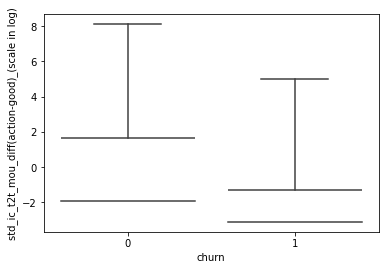

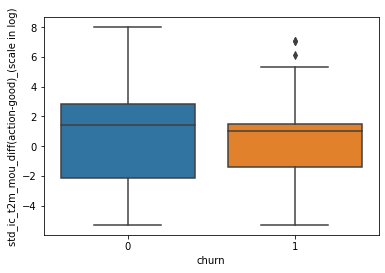

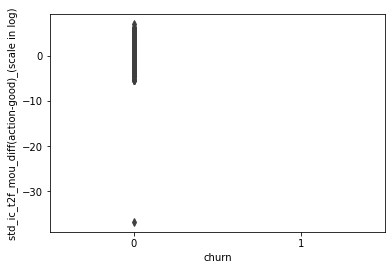

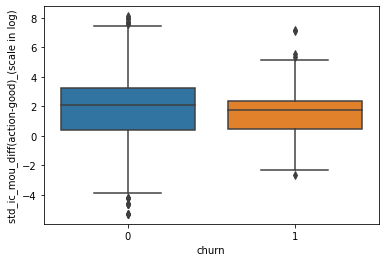

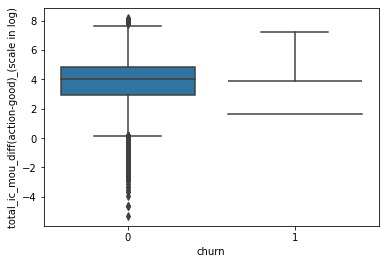

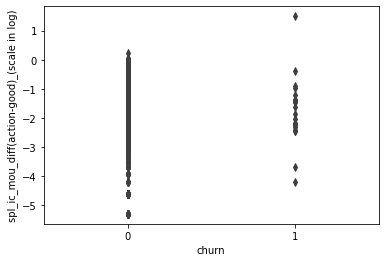

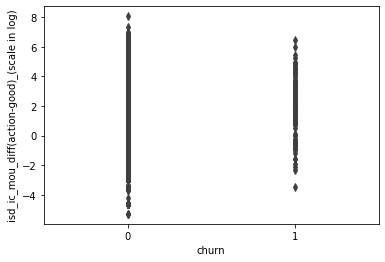

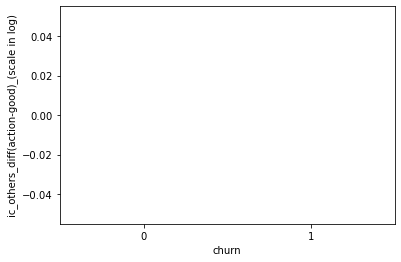

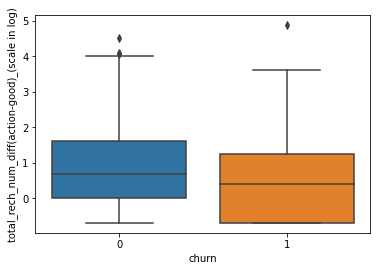

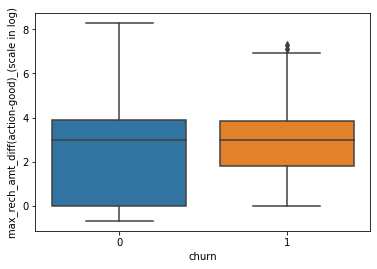

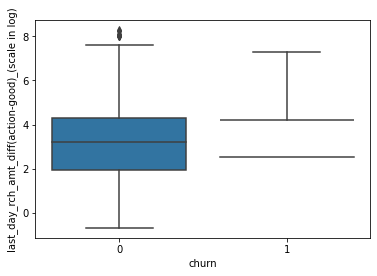

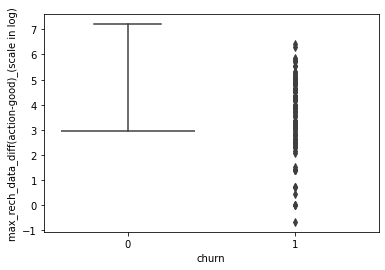

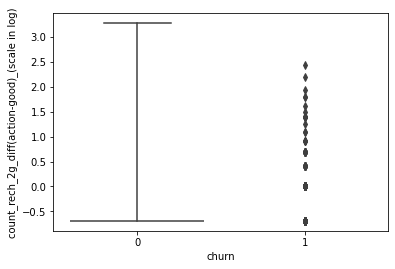

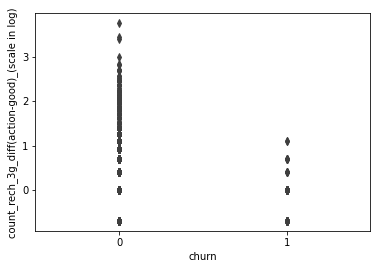

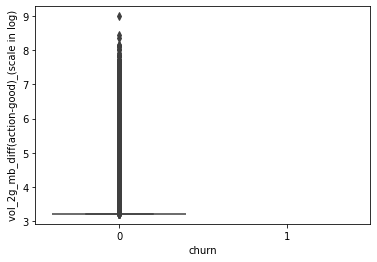

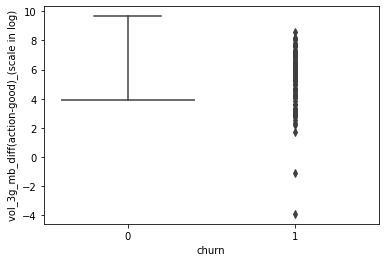

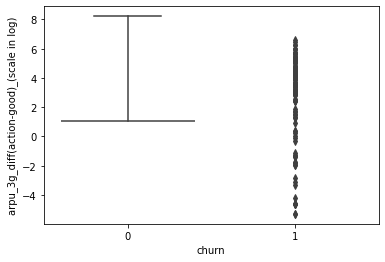

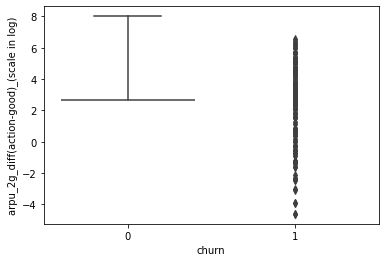

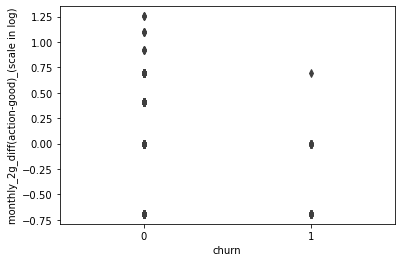

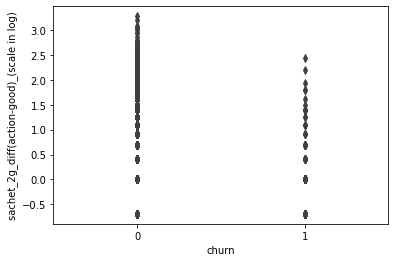

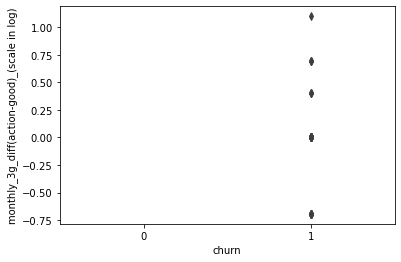

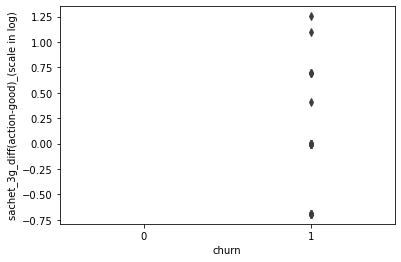

In [68]:
for feature in Continous_features:
    sns.boxplot(data = df_ValueCust, y = np.log(df_ValueCust[feature]),x=df_ValueCust.churn)
    plt.ylabel(f'{feature}_(scale in log)')
    plt.show()

In [69]:
diff  = ['arpu_diff(action-good)','total_og_mou_diff(action-good)','total_ic_mou_diff(action-good)',
         'max_rech_amt_diff(action-good)','max_rech_data_diff(action-good)','arpu_3g_diff(action-good)', 'arpu_2g_diff(action-good)'
        ]

In [70]:
# # Code commented to reduce runtime
# sns.pairplot(df_ValueCust[diff])
# plt.show()

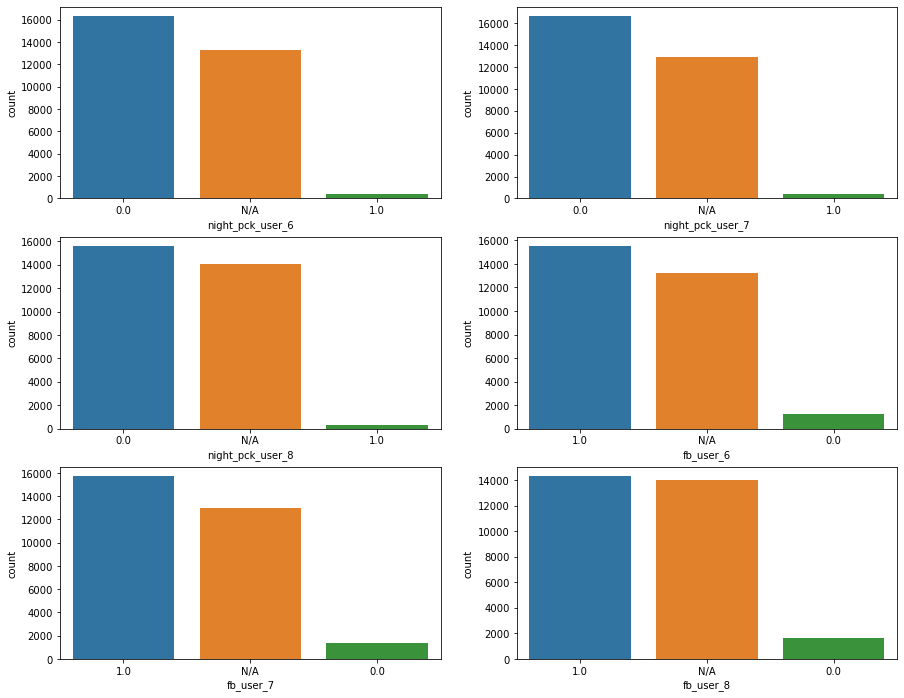

In [71]:
plt.figure(figsize=(15,12))
for i,feature in enumerate(categorical_features): 
    plt.subplot(3,2,(i+1))
    sns.countplot(data=df_ValueCust,x=df_ValueCust[feature])
plt.show()

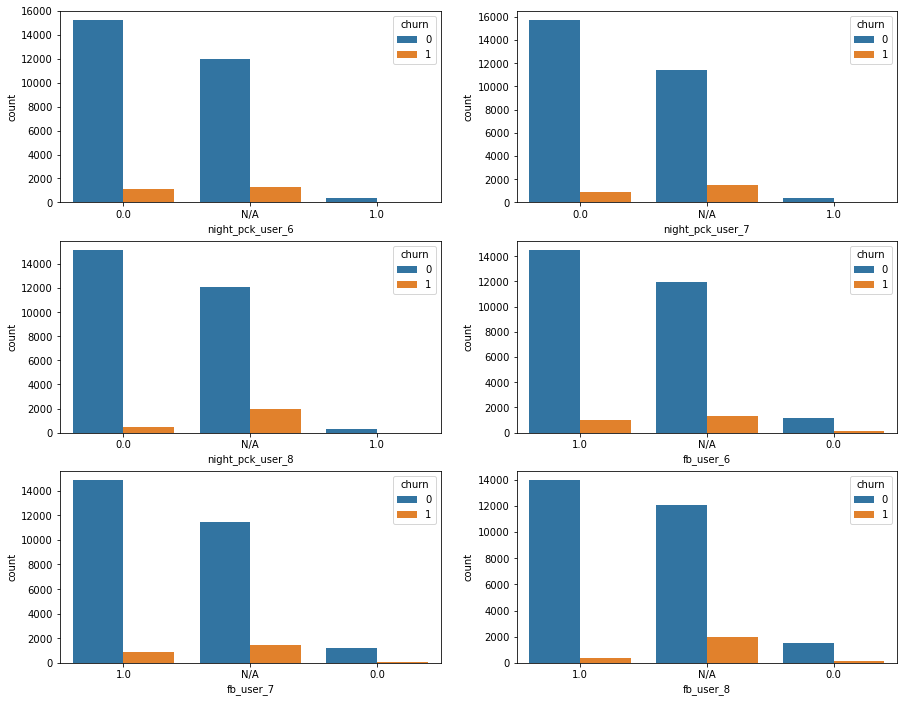

In [72]:
plt.figure(figsize=(15,12))
for i,feature in enumerate(categorical_features):
    plt.subplot(3,2,(i+1))
    sns.countplot(data=df_ValueCust,x=df_ValueCust[feature],hue=df_ValueCust.churn)
plt.show()

In [73]:
## Code commented to reduce runtime
#Checking for correlation between target and predictors as well as for collinearity among predictors.
# plt.figure(figsize=[25,15])
# cor = df_ValueCust.corr()
# sns.heatmap(cor, cmap=plt.cm.Reds, annot=True)
# plt.show()

In [74]:
# From above we can see that there is very high correlation present among variables.

## Data preparation for modelling

In [75]:
y = df_ValueCust.pop('churn')  #extracting target variable from train set
X = df_ValueCust            #extracting predictors from train set

In [76]:
# Creating dummy variables:
dummy_list = list(X.select_dtypes('object').columns)
dummies = pd.get_dummies(X[dummy_list],drop_first=True) #Creating dummies & Dropping one of the levels since it's redundant.
X.drop(dummy_list,axis=1,inplace=True)  #Droping original columns after extracting dummy variables 
X = pd.concat([X,dummies],axis = 1)     #Concating dummy variables to original dataframe
X.shape

(30001, 151)

### Handling class imbalance

In [77]:
smt = SMOTE(random_state=0)  # Creating a smt object using SMOTE().
X_smote, y_smote = smt.fit_resample(X, y)   # Performing oversampling.

In [78]:
# Performing Train-Test split:
np.random.seed(0)  #To initialize a pseudorandom number generator.
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [79]:
y_train.sum()/len(y_train.index)*100

49.92743105950653

<AxesSubplot:>

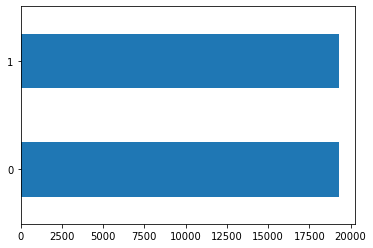

In [80]:
y_train.value_counts().plot(kind='barh')

    * We have gotten rid of class imbalance

In [81]:
# Scaling the data:
scaler = MinMaxScaler()   # Creating a scaler object using MinMaxScaler().
#'transform' and 'Fit' the train set :
X_train[list(X_train.columns)]=scaler.fit_transform(X_train[list(X_train.columns)]) 
# 'transform only' on test set :
X_test[list(X_test.columns)]=scaler.transform(X_test[list(X_test.columns)])

In [82]:
# Creating copies for future
X_train_temp, y_train_temp = X_train.copy(), y_train.copy()
X_test_temp, y_test_temp = X_test.copy(), y_test.copy()

## Model building for classification
* Since objective is to build strong predictive model to determine churn as well as driving factors causing churn, we will build multiple models mainly of two types: one with strong predictive power and other with strong interpretebility.
    * Interpretable models:
        * Logistic model
        * Decision Tree model
        * random forest model
    * strong predictive models :
        * Logistic model with PCA
        * random forest model with PCA 

# Simple Logistic model 

In [83]:
logreg = LogisticRegression()  # Creating a logreg object using LogisticRegression().

In [84]:
# Since We have very large number of predictors, we will use RFE for feature elimination.
rfe = RFE(logreg, 15)             # configuring RFE to return top 15 variables as output
rfe = rfe.fit(X_train, y_train)   # Fitting rfe on train set.

In [85]:
col = X_train.columns[rfe.support_]    #Extracting top 15 rfe selected features
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6',
       'count_rech_3g_6', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_6',
       'monthly_3g_7', 'sachet_3g_6', 'arpu_diff(action-good)',
       'total_og_mou_diff(action-good)', 'total_ic_mou_diff(action-good)',
       'total_rech_num_diff(action-good)',
       'last_day_rch_amt_diff(action-good)',
       'count_rech_2g_diff(action-good)'],
      dtype='object')

In [86]:
# Using StatsModels for statistical parameters like p_values
X_train_sm = sm.add_constant(X_train[col])                           #Adding a constant term.   
#Creating logm1 object of class GLM() i.e., generalized linear model with Binomial() family:
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial()) 
res = logm1.fit()                                                    #Fiting on training data
res.summary()                                                        #Model summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38568
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 25 Aug 2021   Deviance:                          nan
Time:                        21:55:41   Pearson chi2:                 2.77e+07
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 83.3416      1.179     70.660      0.000      81.030      85.653
total_ic_mou_6                       -32.1917      1.061    -30.349      0.000     -34.271     -30.113
total_ic_mou_7                       -20.1742      0.851    -23.709      0.000     -21.842     -18.506
total_rech_num_6                     -14.7421      0.738    -19.986      0.000     -16.188     -13.296
count_rech_3g_6                     1.271e+06   4.21e+07      0.030      0.976   -8.12e+07    8.38e+07
monthly_2g_7                         -10.2826      0.338    -30.383      0.000     -10.946      -9.619
sachet_2g_7                          -14.0243      0.515    -27.221      0.000     -15.034     -13.015
monthly_3g_6                       -6.136e+05   2.03e+07     -0.030      0.976   -4.04e+07    3.92e+07
monthly_3g_7                         -11.7716      0.745    -15.802      0.000     -13.232     -10.312
sachet_3g_6                        -1.271e+06   4.21e+07     -0.030      0.976   -8.38e+07    8.12e+07
arpu_diff(action-good)               -11.3763      0.921    -12.356      0.000     -13.181      -9.572
total_og_mou_diff(action-good)        -6.1858      0.943     -6.562      0.000      -8.033      -4.338
total_ic_mou_diff(action-good)       -78.4276      1.838    -42.670      0.000     -82.030     -74.825
total_rech_num_diff(action-good)     -22.2799      1.179    -18.892      0.000     -24.591     -19.969
last_day_rch_amt_diff(action-good)   -12.7023      0.957    -13.280      0.000     -14.577     -10.828
count_rech_2g_diff(action-good)      -15.3254      0.740    -20.711      0.000     -16.776     -13.875
======================================================================================================
"""

In [87]:
# Using Variance inflation factor (VIF) to check for Multicollinearity:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
12    total_rech_num_diff(action-good)  835.87
11      total_ic_mou_diff(action-good)  689.67
9               arpu_diff(action-good)  563.54
13  last_day_rch_amt_diff(action-good)  436.80
10      total_og_mou_diff(action-good)  296.33
14     count_rech_2g_diff(action-good)  236.12
3                      count_rech_3g_6   30.65
8                          sachet_3g_6   20.41
6                         monthly_3g_6    8.88
0                       total_ic_mou_6    4.68
2                     total_rech_num_6    4.22
1                       total_ic_mou_7    3.87
7                         monthly_3g_7    1.66
5                          sachet_2g_7    1.46
4                         monthly_2g_7    1.14

In [88]:
col = col.drop('count_rech_3g_6', 1)  #droping feature because of high p_value.
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7',
       'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)', 'total_og_mou_diff(action-good)',
       'total_ic_mou_diff(action-good)', 'total_rech_num_diff(action-good)',
       'last_day_rch_amt_diff(action-good)',
       'count_rech_2g_diff(action-good)'],
      dtype='object')

In [89]:
# rebuilding model after droping statistically insignificant feature.
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38569
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15443.
Date:                Wed, 25 Aug 2021   Deviance:                       30887.
Time:                        21:55:41   Pearson chi2:                 2.59e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 82.4035      1.057     77.924      0.000      80.331      84.476
total_ic_mou_6                       -28.4614      0.966    -29.467      0.000     -30.355     -26.568
total_ic_mou_7                       -18.4022      0.784    -23.466      0.000     -19.939     -16.865
total_rech_num_6                     -15.1224      0.685    -22.067      0.000     -16.466     -13.779
monthly_2g_7                         -10.2421      0.301    -34.050      0.000     -10.832      -9.653
sachet_2g_7                          -13.0287      0.446    -29.200      0.000     -13.903     -12.154
monthly_3g_6                          -3.0642      0.458     -6.685      0.000      -3.963      -2.166
monthly_3g_7                          -9.3879      0.589    -15.933      0.000     -10.543      -8.233
sachet_3g_6                           -2.4885      0.483     -5.153      0.000      -3.435      -1.542
arpu_diff(action-good)               -12.8878      0.837    -15.401      0.000     -14.528     -11.248
total_og_mou_diff(action-good)        -3.7868      0.887     -4.271      0.000      -5.525      -2.049
total_ic_mou_diff(action-good)       -74.5035      1.637    -45.524      0.000     -77.711     -71.296
total_rech_num_diff(action-good)     -23.2195      1.119    -20.750      0.000     -25.413     -21.026
last_day_rch_amt_diff(action-good)   -13.6986      0.902    -15.188      0.000     -15.466     -11.931
count_rech_2g_diff(action-good)      -16.5469      0.659    -25.101      0.000     -17.839     -15.255
======================================================================================================
"""

In [90]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
11    total_rech_num_diff(action-good)  835.61
10      total_ic_mou_diff(action-good)  688.54
8               arpu_diff(action-good)  556.37
12  last_day_rch_amt_diff(action-good)  435.65
9       total_og_mou_diff(action-good)  293.66
13     count_rech_2g_diff(action-good)  234.64
0                       total_ic_mou_6    4.67
2                     total_rech_num_6    4.22
1                       total_ic_mou_7    3.85
5                         monthly_3g_6    1.67
6                         monthly_3g_7    1.66
4                          sachet_2g_7    1.46
3                         monthly_2g_7    1.14
7                          sachet_3g_6    1.08

In [91]:
# We will drop below feature because of high VIF which indicates high multicollinearity.
col = col.drop('total_rech_num_diff(action-good)', 1)  
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7',
       'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)', 'total_og_mou_diff(action-good)',
       'total_ic_mou_diff(action-good)', 'last_day_rch_amt_diff(action-good)',
       'count_rech_2g_diff(action-good)'],
      dtype='object')

In [92]:
# rebuilding model after droping highly correlated feature.
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38570
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15688.
Date:                Wed, 25 Aug 2021   Deviance:                       31375.
Time:                        21:55:42   Pearson chi2:                 9.67e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 80.0764      1.055     75.925      0.000      78.009      82.144
total_ic_mou_6                       -31.4056      0.965    -32.552      0.000     -33.297     -29.515
total_ic_mou_7                       -18.2715      0.782    -23.365      0.000     -19.804     -16.739
total_rech_num_6                      -6.5245      0.504    -12.944      0.000      -7.512      -5.537
monthly_2g_7                         -10.2460      0.301    -33.985      0.000     -10.837      -9.655
sachet_2g_7                          -13.3833      0.438    -30.572      0.000     -14.241     -12.525
monthly_3g_6                          -3.1541      0.460     -6.853      0.000      -4.056      -2.252
monthly_3g_7                          -8.8680      0.589    -15.047      0.000     -10.023      -7.713
sachet_3g_6                           -1.9804      0.463     -4.278      0.000      -2.888      -1.073
arpu_diff(action-good)               -19.7841      0.795    -24.875      0.000     -21.343     -18.225
total_og_mou_diff(action-good)        -6.3556      0.897     -7.089      0.000      -8.113      -4.599
total_ic_mou_diff(action-good)       -80.7116      1.641    -49.182      0.000     -83.928     -77.495
last_day_rch_amt_diff(action-good)   -13.3580      0.907    -14.729      0.000     -15.136     -11.581
count_rech_2g_diff(action-good)      -20.1585      0.630    -32.000      0.000     -21.393     -18.924
======================================================================================================
"""

In [93]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
10      total_ic_mou_diff(action-good)  588.08
8               arpu_diff(action-good)  500.87
11  last_day_rch_amt_diff(action-good)  433.14
9       total_og_mou_diff(action-good)  279.76
12     count_rech_2g_diff(action-good)  189.45
0                       total_ic_mou_6    4.51
1                       total_ic_mou_7    3.83
2                     total_rech_num_6    3.26
5                         monthly_3g_6    1.67
6                         monthly_3g_7    1.65
4                          sachet_2g_7    1.44
3                         monthly_2g_7    1.14
7                          sachet_3g_6    1.08

In [94]:
# We will drop below feature because of high VIF which indicates high multicollinearity.
col = col.drop('count_rech_2g_diff(action-good)', 1)
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7',
       'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)', 'total_og_mou_diff(action-good)',
       'total_ic_mou_diff(action-good)', 'last_day_rch_amt_diff(action-good)'],
      dtype='object')

In [95]:
# rebuilding model after droping highly correlated feature.
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38571
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16417.
Date:                Wed, 25 Aug 2021   Deviance:                       32834.
Time:                        21:55:42   Pearson chi2:                 2.40e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 75.8143      1.052     72.073      0.000      73.753      77.876
total_ic_mou_6                       -34.1115      0.973    -35.061      0.000     -36.018     -32.205
total_ic_mou_7                       -20.4697      0.784    -26.120      0.000     -22.006     -18.934
total_rech_num_6                      -5.1736      0.491    -10.530      0.000      -6.137      -4.211
monthly_2g_7                          -9.4612      0.295    -32.042      0.000     -10.040      -8.882
sachet_2g_7                           -5.1440      0.273    -18.824      0.000      -5.680      -4.608
monthly_3g_6                          -4.0578      0.464     -8.742      0.000      -4.968      -3.148
monthly_3g_7                          -9.0264      0.594    -15.206      0.000     -10.190      -7.863
sachet_3g_6                           -0.9700      0.433     -2.242      0.025      -1.818      -0.122
arpu_diff(action-good)               -24.5262      0.817    -30.035      0.000     -26.127     -22.926
total_og_mou_diff(action-good)        -1.5096      0.885     -1.705      0.088      -3.245       0.226
total_ic_mou_diff(action-good)       -88.4432      1.658    -53.343      0.000     -91.693     -85.194
last_day_rch_amt_diff(action-good)   -13.2954      0.931    -14.278      0.000     -15.121     -11.470
======================================================================================================
"""

In [96]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
10      total_ic_mou_diff(action-good)  505.29
8               arpu_diff(action-good)  492.82
11  last_day_rch_amt_diff(action-good)  422.23
9       total_og_mou_diff(action-good)  277.62
0                       total_ic_mou_6    4.41
1                       total_ic_mou_7    3.83
2                     total_rech_num_6    3.26
5                         monthly_3g_6    1.66
6                         monthly_3g_7    1.65
4                          sachet_2g_7    1.25
3                         monthly_2g_7    1.13
7                          sachet_3g_6    1.08

In [97]:
# We will drop below feature because of high VIF which indicates high multicollinearity.
col = col.drop('last_day_rch_amt_diff(action-good)', 1)
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7',
       'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)', 'total_og_mou_diff(action-good)',
       'total_ic_mou_diff(action-good)'],
      dtype='object')

In [98]:
# rebuilding model after droping highly correlated feature.
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38572
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16525.
Date:                Wed, 25 Aug 2021   Deviance:                       33050.
Time:                        21:55:43   Pearson chi2:                 2.53e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             71.3357      0.991     71.972      0.000      69.393      73.278
total_ic_mou_6                   -34.6298      0.970    -35.703      0.000     -36.531     -32.729
total_ic_mou_7                   -20.2365      0.780    -25.948      0.000     -21.765     -18.708
total_rech_num_6                  -6.0005      0.490    -12.246      0.000      -6.961      -5.040
monthly_2g_7                      -9.5302      0.294    -32.396      0.000     -10.107      -8.954
sachet_2g_7                       -5.3270      0.274    -19.473      0.000      -5.863      -4.791
monthly_3g_6                      -3.8779      0.458     -8.466      0.000      -4.776      -2.980
monthly_3g_7                      -8.9772      0.585    -15.343      0.000     -10.124      -7.830
sachet_3g_6                       -1.0750      0.434     -2.477      0.013      -1.926      -0.224
arpu_diff(action-good)           -26.4831      0.807    -32.807      0.000     -28.065     -24.901
total_og_mou_diff(action-good)    -1.2411      0.884     -1.404      0.160      -2.973       0.491
total_ic_mou_diff(action-good)   -88.8613      1.658    -53.593      0.000     -92.111     -85.612
==================================================================================================
"""

In [99]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
8           arpu_diff(action-good)  456.40
10  total_ic_mou_diff(action-good)  289.19
9   total_og_mou_diff(action-good)  277.18
0                   total_ic_mou_6    4.06
1                   total_ic_mou_7    3.78
2                 total_rech_num_6    3.16
5                     monthly_3g_6    1.66
6                     monthly_3g_7    1.65
4                      sachet_2g_7    1.25
3                     monthly_2g_7    1.13
7                      sachet_3g_6    1.08

In [100]:
# We will drop below feature because of high VIF which indicates high multicollinearity.
col = col.drop('total_og_mou_diff(action-good)', 1)
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7',
       'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)', 'total_ic_mou_diff(action-good)'],
      dtype='object')

In [101]:
# rebuilding model after droping highly correlated feature.
X_train_sm = sm.add_constant(X_train[col])
logm6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38573
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16526.
Date:                Wed, 25 Aug 2021   Deviance:                       33052.
Time:                        21:55:43   Pearson chi2:                 2.61e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             71.4903      0.986     72.479      0.000      69.557      73.424
total_ic_mou_6                   -34.7513      0.967    -35.925      0.000     -36.647     -32.855
total_ic_mou_7                   -20.2414      0.781    -25.925      0.000     -21.772     -18.711
total_rech_num_6                  -5.8887      0.483    -12.197      0.000      -6.835      -4.942
monthly_2g_7                      -9.5566      0.294    -32.531      0.000     -10.132      -8.981
sachet_2g_7                       -5.3804      0.271    -19.842      0.000      -5.912      -4.849
monthly_3g_6                      -3.9653      0.455     -8.716      0.000      -4.857      -3.074
monthly_3g_7                      -9.0206      0.585    -15.413      0.000     -10.168      -7.873
sachet_3g_6                       -1.1378      0.432     -2.631      0.009      -1.985      -0.290
arpu_diff(action-good)           -27.1713      0.645    -42.117      0.000     -28.436     -25.907
total_ic_mou_diff(action-good)   -89.2358      1.639    -54.449      0.000     -92.448     -86.024
==================================================================================================
"""

In [102]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
9  total_ic_mou_diff(action-good)  278.57
8          arpu_diff(action-good)  275.15
0                  total_ic_mou_6    4.05
1                  total_ic_mou_7    3.78
2                total_rech_num_6    3.05
5                    monthly_3g_6    1.65
6                    monthly_3g_7    1.65
4                     sachet_2g_7    1.24
3                    monthly_2g_7    1.13
7                     sachet_3g_6    1.07

In [103]:
# We will drop below feature because of high VIF which indicates high multicollinearity.
col = col.drop('total_ic_mou_diff(action-good)', 1)
col

Index(['total_ic_mou_6', 'total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7',
       'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)'],
      dtype='object')

In [104]:
# rebuilding model after droping highly correlated feature.
X_train_sm = sm.add_constant(X_train[col])
logm6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38574
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18993.
Date:                Wed, 25 Aug 2021   Deviance:                       37987.
Time:                        21:55:43   Pearson chi2:                 9.48e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     24.5393      0.326     75.191      0.000      23.900      25.179
total_ic_mou_6             0.4969      0.534      0.930      0.352      -0.550       1.544
total_ic_mou_7           -16.7955      0.615    -27.307      0.000     -18.001     -15.590
total_rech_num_6          -8.3458      0.457    -18.255      0.000      -9.242      -7.450
monthly_2g_7              -9.8028      0.280    -35.044      0.000     -10.351      -9.255
sachet_2g_7               -4.0576      0.253    -16.052      0.000      -4.553      -3.562
monthly_3g_6              -3.9852      0.441     -9.045      0.000      -4.849      -3.122
monthly_3g_7             -10.6653      0.559    -19.062      0.000     -11.762      -9.569
sachet_3g_6               -0.8926      0.421     -2.118      0.034      -1.719      -0.067
arpu_diff(action-good)   -45.4084      0.617    -73.613      0.000     -46.617     -44.199
==========================================================================================
"""

In [105]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0          total_ic_mou_6  3.92
1          total_ic_mou_7  3.78
8  arpu_diff(action-good)  3.69
2        total_rech_num_6  2.74
6            monthly_3g_7  1.65
5            monthly_3g_6  1.64
4             sachet_2g_7  1.22
3            monthly_2g_7  1.13
7             sachet_3g_6  1.07

In [106]:
col = col.drop('total_ic_mou_6', 1)   #droping feature because of high p_value.
col

Index(['total_ic_mou_7', 'total_rech_num_6', 'monthly_2g_7', 'sachet_2g_7',
       'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6',
       'arpu_diff(action-good)'],
      dtype='object')

In [107]:
# rebuilding model after droping statistically insignificant feature.
X_train_sm = sm.add_constant(X_train[col])
logm7 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38584
Model:                            GLM   Df Residuals:                    38575
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18994.
Date:                Wed, 25 Aug 2021   Deviance:                       37988.
Time:                        21:55:43   Pearson chi2:                 9.64e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     24.5736      0.324     75.749      0.000      23.938      25.209
total_ic_mou_7           -16.3796      0.421    -38.936      0.000     -17.204     -15.555
total_rech_num_6          -8.3045      0.455    -18.252      0.000      -9.196      -7.413
monthly_2g_7              -9.8048      0.280    -35.049      0.000     -10.353      -9.257
sachet_2g_7               -4.0716      0.252    -16.133      0.000      -4.566      -3.577
monthly_3g_6              -3.9789      0.440     -9.034      0.000      -4.842      -3.116
monthly_3g_7             -10.6811      0.559    -19.098      0.000     -11.777      -9.585
sachet_3g_6               -0.8979      0.421     -2.131      0.033      -1.724      -0.072
arpu_diff(action-good)   -45.4711      0.613    -74.129      0.000     -46.673     -44.269
==========================================================================================
"""

In [108]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
7  arpu_diff(action-good)  3.66
1        total_rech_num_6  2.68
5            monthly_3g_7  1.65
4            monthly_3g_6  1.64
0          total_ic_mou_7  1.53
3             sachet_2g_7  1.22
2            monthly_2g_7  1.13
6             sachet_3g_6  1.07

* since all p_values are low(<0.05) and VIF is also low(<5), we will finalize above model

* log(odds of churning) = 24.5736 + [total_ic_mou_7 * (-16.3796)] + [total_rech_num_6 * (-8.3045)] + [monthly_2g_7 * (-9.8048)] + [sachet_2g_7 * (-4.0716)] + [monthly_3g_6 * (-3.9789)] + [monthly_3g_7 * (-10.6811)] + [sachet_3g_6 * (-0.8979)] + [arpu_diff(action-good)	* (-45.4711)]
                              
* e.g. when everything else is kept constant in above eqn, a unit increase in total_ic_mou_7 will decrease log(odds) by -16.3796 units.

In [109]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [110]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final.head()

Churn  Churn_Prob
0      0    0.036401
1      1    0.518391
2      0    0.037368
3      0    0.146049
4      0    0.504361

* Deciding value of threshold:

In [111]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0      0    0.036401    1    0    0    0    0    0    0    0    0    0
1      1    0.518391    1    1    1    1    1    1    0    0    0    0
2      0    0.037368    1    0    0    0    0    0    0    0    0    0
3      0    0.146049    1    1    0    0    0    0    0    0    0    0
4      0    0.504361    1    1    1    1    1    1    0    0    0    0

In [112]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.499274  1.000000  0.000000
0.1   0.1  0.594599  0.976952  0.213354
0.2   0.2  0.662788  0.954475  0.371946
0.3   0.3  0.715919  0.918605  0.513820
0.4   0.4  0.759512  0.865345  0.653986
0.5   0.5  0.783148  0.786960  0.779348
0.6   0.6  0.770889  0.672654  0.868841
0.7   0.7  0.735123  0.543086  0.926605
0.8   0.8  0.677457  0.391923  0.962164
0.9   0.9  0.575601  0.163154  0.986853


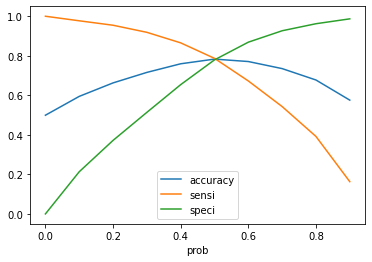

In [113]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

    * As we know there is a trade off between specificity and sensitivity.
    * We can see that optimal value of threshold is around 0.5
    * Since our priority is to correctly predict churn, we will use Recall / sensitivity metric for model evaluation.
    * For a stronger churn prevention policy we can use lower threshold values than 0.5

In [114]:
#Model prediction and evalution on test data:
X_test = X_test[col]
X_test.head()

total_ic_mou_7  total_rech_num_6  monthly_2g_7  sachet_2g_7  \
22210        0.034716          0.016287           0.4          0.0   
48205        0.018340          0.052117           0.0          0.0   
28405        0.001455          0.140065           0.0          0.0   
52450        0.004186          0.039088           0.0          0.0   
41216        0.000845          0.013029           0.0          0.0   

       monthly_3g_6  monthly_3g_7  sachet_3g_6  arpu_diff(action-good)  
22210           0.0           0.0          0.0                0.532629  
48205           0.0           0.0          0.0                0.518282  
28405           0.0           0.0          0.0                0.481051  
52450           0.0           0.0          0.0                0.482346  
41216           0.0           0.0          0.0                0.543344

In [115]:
X_test_sm = sm.add_constant(X_test)

In [116]:
y_test_pred = res.predict(X_test_sm).values.reshape(-1)

In [117]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final.head()

Churn  Churn_Prob
0      0    0.013769
1      1    0.567960
2      1    0.819456
3      1    0.904444
4      1    0.436621

In [118]:
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

Churn  Churn_Prob  predicted
0      0    0.013769          0
1      1    0.567960          1
2      1    0.819456          1
3      1    0.904444          1
4      1    0.436621          0

In [119]:
simple_logit = metrics.recall_score(y_test_pred_final.Churn, y_test_pred_final.predicted)
print(f'Recall score for simple logit model is {round(simple_logit*100,2)}%')

Recall score for simple logit model is 78.42%


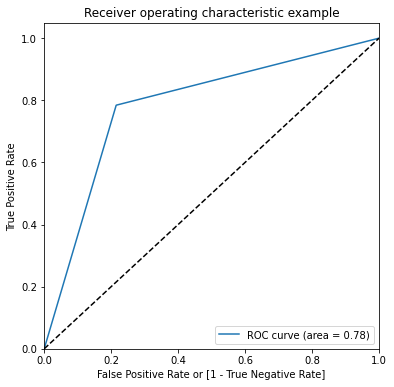

(array([0.        , 0.21504854, 1.        ]),
 array([0.        , 0.78423337, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [120]:
draw_roc(y_test_pred_final.Churn, y_test_pred_final.predicted)

# Simple Decision Tree model

In [121]:
X_train, y_train = X_train_temp, y_train_temp 
X_test, y_test = X_test_temp, y_test_temp

In [122]:
dt = DecisionTreeClassifier(random_state=42)

In [123]:
# Hyperparameter tuning using GridSearchCV
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "recall") # Instantiate the grid search model

In [124]:
grid_search.fit(X_train, y_train) #fiting on train set

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [125]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [126]:
dt_best = grid_search.best_estimator_

Train Recall : 0.9473110465116279
Train Confusion Matrix:
[[17851  1469]
 [ 1015 18249]]
--------------------------------------------------
Test recall : 0.9162246865959498
Test Confusion Matrix:
[[7317  923]
 [ 695 7601]]


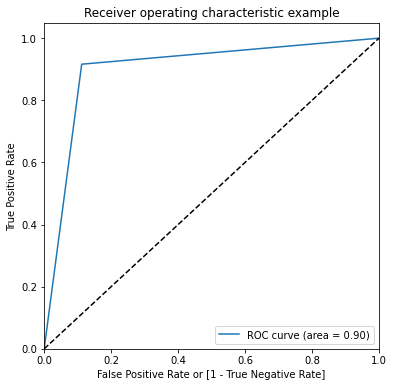

In [127]:
evaluate_model(dt_best)

In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      8240
           1       0.89      0.92      0.90      8296

    accuracy                           0.90     16536
   macro avg       0.90      0.90      0.90     16536
weighted avg       0.90      0.90      0.90     16536



In [129]:
simple_DT = recall_score(y_test, dt_best.predict(X_test))
print(f'Recall score of simple DT is {round(simple_DT*100,2)}%')

Recall score of simple DT is 91.62%


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.580347 to fit



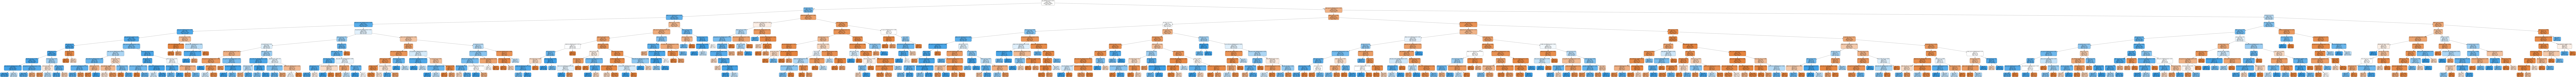

In [130]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())

* Above DT is not that much interpretable because of its size

# Simple Random Forest model with smote

In [131]:
X_train, y_train = X_train_temp, y_train_temp 
X_test, y_test = X_test_temp, y_test_temp

In [132]:
#Creating rf object of RandomForestClassifier()
rf = RandomForestClassifier(random_state=42, n_jobs=-1) 

In [133]:
# GridSearchCV for hyperparametr tuning:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,                                           
                           n_jobs=-1, verbose=1, scoring="recall")    #4 folds, scoring="recall"

In [134]:
grid_search.fit(X_train, y_train)  #fitting on train set

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='recall', verbose=1)

In [135]:
grid_search.best_score_

0.9485049833887043

In [136]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

* Model evalution on test set:

In [137]:
y_test_pred=rf_best.predict(X_test)

In [138]:
simple_random_forest = metrics.recall_score(y_test, y_test_pred)
print(f'Recall score for simple Random forest model is {round(simple_random_forest*100,2)}%')

Recall score for simple Random forest model is 96.05%


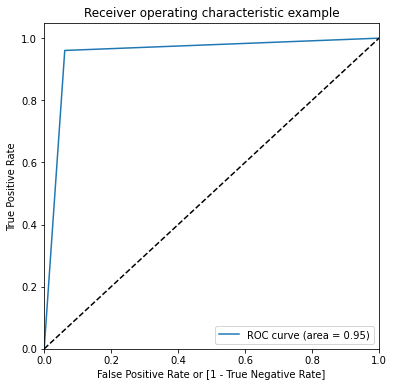

(array([0.        , 0.06140777, 1.        ]),
 array([0.        , 0.96046287, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [139]:
draw_roc(y_test, y_test_pred)

In [140]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [141]:
imp_df.sort_values(by="Imp", ascending=False)[:10]

Varname       Imp
149                       fb_user_8_1.0  0.062586
94           total_amt[8-(6&7_avg)]diff  0.057513
95               arpu_diff(action-good)  0.056112
127  last_day_rch_amt_diff(action-good)  0.050135
125    total_rech_num_diff(action-good)  0.041424
121      total_ic_mou_diff(action-good)  0.039754
126      max_rech_amt_diff(action-good)  0.034693
98        roam_ic_mou_diff(action-good)  0.030742
112      total_og_mou_diff(action-good)  0.028512
99        roam_og_mou_diff(action-good)  0.027673

* Above are top most significant features as per RF, but it does not indicate direction/polarity of correlation with target variable.

# Simple Random Forest model with class weight

In [142]:
np.random.seed(0)  #To initialize a pseudorandom number generator.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [143]:
scaler = MinMaxScaler()   # Creating a scaler object using MinMaxScaler().
#'transform' and 'Fit' the train set :
X_train[list(X_train.columns)]=scaler.fit_transform(X_train[list(X_train.columns)]) 
# 'transform only' on test set :
X_test[list(X_test.columns)]=scaler.transform(X_test[list(X_test.columns)])

In [144]:
rf = RandomForestClassifier(class_weight={0:0.08,1:0.92},random_state=42, n_jobs=-1)

In [145]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [146]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="recall")

In [147]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight={0: 0.08, 1: 0.92},
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='recall', verbose=1)

In [148]:
grid_search.best_score_

0.7936091784029667

In [149]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(class_weight={0: 0.08, 1: 0.92}, max_depth=20,
                       min_samples_leaf=200, n_estimators=10, n_jobs=-1,
                       random_state=42)

* Model evalution on test set:

In [150]:
y_test_pred=rf_best.predict(X_test)

In [151]:
simple_random_forest_class_wt = metrics.recall_score(y_test, y_test_pred)
print(f'Recall score for simple Random forest model with class_weight method is {round(simple_random_forest_class_wt*100,2)}%')

Recall score for simple Random forest model with class_weight method is 79.87%


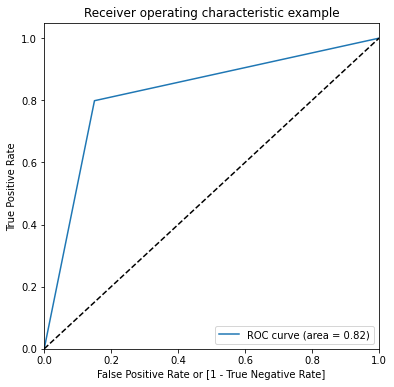

(array([0.        , 0.15016362, 1.        ]),
 array([0.        , 0.79866667, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [152]:
draw_roc(y_test, y_test_pred)    #Plots ROC curve

In [153]:
# feature importance as per random forset
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [154]:
imp_df.sort_values(by="Imp", ascending=False)[:10] #Top 10 important features as per random forset

Varname       Imp
125  total_rech_num_diff(action-good)  0.111936
95             arpu_diff(action-good)  0.105779
144              night_pck_user_8_N/A  0.097544
94         total_amt[8-(6&7_avg)]diff  0.068880
121    total_ic_mou_diff(action-good)  0.049238
108      std_og_mou_diff(action-good)  0.038221
97       offnet_mou_diff(action-good)  0.035810
126    max_rech_amt_diff(action-good)  0.029551
131       vol_2g_mb_diff(action-good)  0.029081
150                     fb_user_8_N/A  0.025199

## Dimensionality reduction using PCA:
* We have very high number of predictors and also these are highly correlated thus we can use PCA.
* Since features are correlated, there wont be issue of forceful dimensionality reduction.
* PCA is fundamentally a dimenssionality reduction technique. It also helps in :
    * EDA and data visualization
    * By transforming data into orthogonal components,it handles multicollinearity and makes model more stable and improves model performance.
* Disadvatage of PCA :
    * New orthogonal components obtained are not same as original features thus we lose interpretability.

# Logit model with PCA

In [155]:
X_train, y_train = X_train_temp, y_train_temp 
X_test, y_test = X_test_temp, y_test_temp

In [156]:
pca = PCA(random_state=42)     #Creating pca object of PCA()

In [157]:
pca.fit(X_train)                #Fiting on X_train

PCA(random_state=42)

In [158]:
pca.components_                #Getting orthogonal components

array([[-5.50376921e-03, -3.16121645e-03, -1.70328034e-02, ...,
        -3.56913194e-01,  2.79907181e-01, -3.19403174e-01],
       [ 2.20203664e-04,  7.98597420e-03,  9.34893207e-03, ...,
         9.29861001e-02,  3.54848132e-01, -4.84371331e-01],
       [ 7.94013465e-03, -5.17882405e-03,  2.28681280e-03, ...,
         5.12350431e-01,  1.35243624e-01, -1.96345750e-01],
       ...,
       [ 0.00000000e+00,  1.46475803e-16, -4.90677365e-16, ...,
        -3.08794431e-03,  1.49987289e-17,  1.09675387e-03],
       [-0.00000000e+00, -2.41947855e-16,  2.06094394e-16, ...,
        -2.58290684e-03,  4.11089213e-17, -1.94791335e-03],
       [ 0.00000000e+00,  2.44824399e-17, -2.70846550e-15, ...,
         2.08806978e-02,  1.32569339e-17, -7.02975053e-03]])

In [159]:
pca.explained_variance_ratio_          #variance explained by each Principal Component

array([5.81835247e-01, 1.41346522e-01, 9.40507437e-02, 5.18723919e-02,
       2.13815153e-02, 2.00256019e-02, 1.70077672e-02, 9.74870523e-03,
       6.22437117e-03, 5.62618199e-03, 5.38509892e-03, 4.62907655e-03,
       4.06332991e-03, 3.10195105e-03, 2.15644999e-03, 1.98696732e-03,
       1.78185199e-03, 1.72675371e-03, 1.50674018e-03, 1.23636397e-03,
       1.19329228e-03, 1.17008842e-03, 1.11167430e-03, 1.01230803e-03,
       9.63017223e-04, 9.07631804e-04, 8.82763394e-04, 8.00411517e-04,
       7.72639836e-04, 7.59277313e-04, 7.22164534e-04, 6.84004367e-04,
       6.38560768e-04, 6.14418494e-04, 5.59365233e-04, 5.32121875e-04,
       5.12318583e-04, 4.93533003e-04, 4.80540381e-04, 4.27262011e-04,
       4.07627423e-04, 3.78684437e-04, 3.56158286e-04, 3.22251989e-04,
       3.05784048e-04, 2.72681091e-04, 2.70038305e-04, 2.53843871e-04,
       2.50993949e-04, 2.28104387e-04, 2.04670257e-04, 2.03190132e-04,
       1.94747086e-04, 1.88643926e-04, 1.85139658e-04, 1.75110262e-04,
      

In [160]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)    #Calculating cumulative variance 

In [161]:
var_cumu                                               #Cumulative variance 

array([0.58183525, 0.72318177, 0.81723251, 0.8691049 , 0.89048642,
       0.91051202, 0.92751979, 0.93726849, 0.94349287, 0.94911905,
       0.95450415, 0.95913322, 0.96319655, 0.9662985 , 0.96845495,
       0.97044192, 0.97222377, 0.97395053, 0.97545727, 0.97669363,
       0.97788692, 0.97905701, 0.98016869, 0.98118099, 0.98214401,
       0.98305164, 0.98393441, 0.98473482, 0.98550746, 0.98626674,
       0.9869889 , 0.9876729 , 0.98831147, 0.98892588, 0.98948525,
       0.99001737, 0.99052969, 0.99102322, 0.99150376, 0.99193102,
       0.99233865, 0.99271734, 0.99307349, 0.99339575, 0.99370153,
       0.99397421, 0.99424425, 0.99449809, 0.99474909, 0.99497719,
       0.99518186, 0.99538505, 0.9955798 , 0.99576844, 0.99595358,
       0.99612869, 0.99629982, 0.99646891, 0.99663224, 0.99679172,
       0.99694822, 0.9970958 , 0.99724045, 0.99737393, 0.99750521,
       0.99763163, 0.9977409 , 0.99784489, 0.99794687, 0.99804514,
       0.99814104, 0.99823615, 0.99832733, 0.99841372, 0.99849

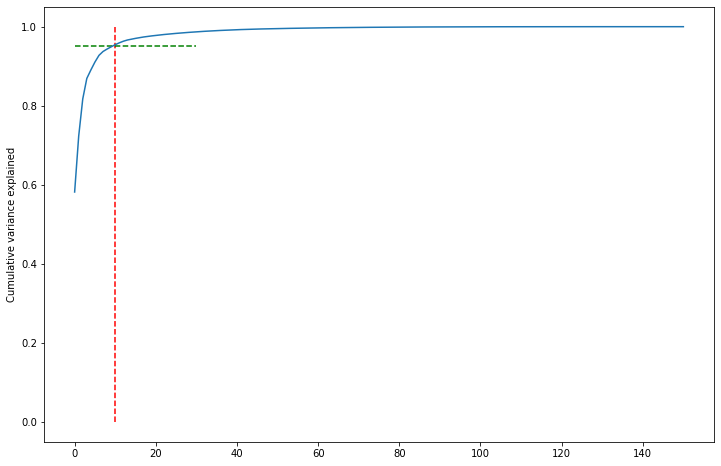

In [162]:
# Plotting scree plot
fig = plt.figure(figsize=[12,8])
plt.vlines(x=10, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [163]:
from sklearn.decomposition import IncrementalPCA

In [164]:
#Tuning for 10 prinipal components which offers highest explained variance which is around 95%
pca_final = IncrementalPCA(n_components=10)  

In [165]:
df_train_pca = pca_final.fit_transform(X_train)  #Fit & transform on train data
df_train_pca.shape

(38584, 10)

<AxesSubplot:>

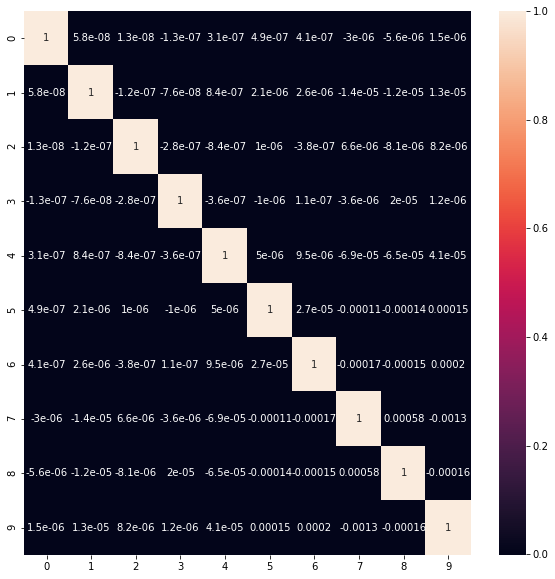

In [166]:
#Heatmap of correlation matrix to check multicollinearity among principal components
corrmat = np.corrcoef(df_train_pca.transpose())
plt.figure(figsize=[10,10])
sns.heatmap(corrmat, annot=True)

* Heatmap confirms that there is no multicollinearity among principal components

In [167]:
df_test_pca = pca_final.transform(X_test)    #Transform only on test data
df_test_pca.shape

(16536, 10)

* Now we will build logit model with Principal components as input

In [168]:
learner_pca = LogisticRegression()

In [169]:
# Fitting logit model on Principal components of train data
model_pca = learner_pca.fit(df_train_pca, y_train)

* Deciding value of threshold:

In [170]:
# Predicting on train set for probability threshold value tuning
pred_probs_train = model_pca.predict_proba(df_train_pca)

In [171]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':pred_probs_train[:,1]})
y_train_pred_final.head()

Churn  Churn_Prob
0      0    0.078329
1      1    0.170987
2      0    0.065089
3      0    0.183268
4      0    0.565195

In [172]:
numbers = [float(x)/10 for x in range(10)] 
for i in numbers: 
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0) 
y_train_pred_final.head()

Churn  Churn_Prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0      0    0.078329    1    0    0    0    0    0    0    0    0    0
1      1    0.170987    1    1    0    0    0    0    0    0    0    0
2      0    0.065089    1    0    0    0    0    0    0    0    0    0
3      0    0.183268    1    1    0    0    0    0    0    0    0    0
4      0    0.565195    1    1    1    1    1    1    0    0    0    0

In [173]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.499274  1.000000  0.000000
0.1   0.1  0.622408  0.988476  0.257402
0.2   0.2  0.726519  0.950114  0.503571
0.3   0.3  0.752851  0.921044  0.585145
0.4   0.4  0.761274  0.887978  0.634938
0.5   0.5  0.766406  0.833160  0.699845
0.6   0.6  0.755132  0.713767  0.796377
0.7   0.7  0.714052  0.534001  0.893582
0.8   0.8  0.644671  0.332226  0.956211
0.9   0.9  0.568448  0.153187  0.982505


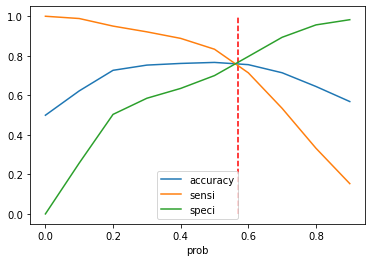

In [174]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.57, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

    * The optimal value of threshold is around 0.57
    * Since we want to prioritize predicting churn, we will chose lower probability value of 0.5 as threshold since we want higher recall score.

* Model evalution on test set:

In [175]:
# predicting on Principal components of test data
pred_probs_test = model_pca.predict_proba(df_test_pca)

In [176]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':pred_probs_test[:,1]}) 

In [177]:
y_test_pred_final.head()

Churn  Churn_Prob
0      0    0.034475
1      1    0.583578
2      1    0.659520
3      1    0.588492
4      1    0.636094

In [178]:
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

Churn  Churn_Prob  predicted
0      0    0.034475          0
1      1    0.583578          1
2      1    0.659520          1
3      1    0.588492          1
4      1    0.636094          1

In [179]:
logit_pca = metrics.recall_score(y_test_pred_final.Churn,y_test_pred_final.predicted)
print(f'Recall score for logit with pca is {round(logit_pca*100,2)}%')

Recall score for logit with pca is 82.55%


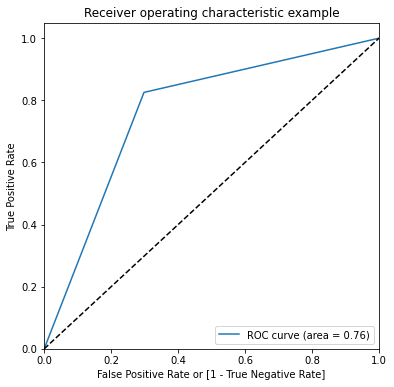

In [180]:
# plots roc curve
draw_roc(y_test_pred_final.Churn, y_test_pred_final.predicted) 
plt.show()

# Random forest with PCA

In [181]:
X_train, y_train = X_train_temp.copy(), y_train_temp.copy()
X_test, y_test = X_test_temp.copy(), y_test_temp.copy()

* Instead of using scree plot to decide number of components, lets make this process a little unsupervised by asking pca to provide minimum number of principal components that explains mentioned variance.  

In [182]:
pca_again = PCA(0.95)                               #Explained variance = 95%

In [183]:
df_train_pca2 = pca_again.fit_transform(X_train)    #Fit and transform, on train data
print(df_train_pca2.shape)
# first 11 components explain 95% variance in the data. 

(38584, 11)


In [184]:
df_test_pca2 = pca_again.transform(X_test)          #Transform only on test data
print(df_test_pca2.shape)

(16536, 11)


* Lets build Random forest on principal components

In [185]:
rf_pca = RandomForestClassifier(random_state=42, n_jobs=-1)

In [186]:
# Hyperparameter tuning using GridSearchCV
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf_pca,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="recall")

In [187]:
grid_search.fit(df_train_pca2, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='recall', verbose=1)

In [188]:
rf_best = grid_search.best_estimator_       #Getting optimal values of hyperparameters
rf_best

RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [189]:
y_test_pred = rf_best.predict(df_test_pca2)     # Predicting on test set

In [190]:
RF_pca = metrics.recall_score(y_test,y_test_pred)
print(f'Recall score for random forest with pca is {round(RF_pca*100,2)}%')

Recall score for random forest with pca is 89.62%


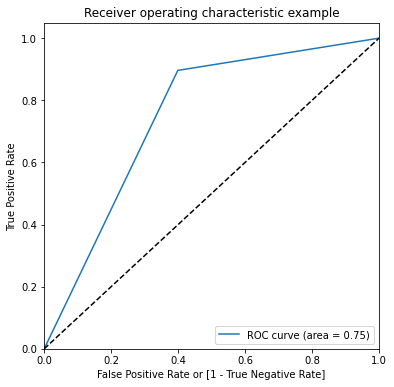

In [191]:
# plots roc curve
draw_roc(y_test, y_test_pred) 
plt.show()

In [192]:
recall_data={'model_name':['simle logit with smote','simple DT with smote','Simple RF with smote',
               'Simple RF with class weight','logit with PCA','RF with PCA'],
 'Recall_score':[simple_logit,simple_DT,simple_random_forest,simple_random_forest_class_wt,
                logit_pca,RF_pca]}

In [193]:
recall_df = pd.DataFrame(recall_data)

In [194]:
recall_df

model_name  Recall_score
0       simle logit with smote      0.784233
1         simple DT with smote      0.916225
2         Simple RF with smote      0.960463
3  Simple RF with class weight      0.798667
4               logit with PCA      0.825458
5                  RF with PCA      0.896215

# Conclusion
* <font color=orange> For strong prediction we will use RF with PCA </font> because of following reasons:
    * simple DT with smote offers high recall score, but DT are tend to overfit. Hence we will not use this model.
    * Simple RF with smote also offers very high recall score but computational complexity is higher and in return it performs slower for large number of features.
    * RF with PCA also offers sufficiently high recall score with additional benefit of stable model thus better perfomance due to removal of multicollinearity by performing dimensionality reduction.
* <font color=orange> For interpretibility we will use simle logit with smote </font> because of following reasons:
    * Models trained on PCA does not offer interpretibility as principal components are not same as original features and thus they lose interpretibility.
    * simple DT with smote tends to overfit and become quite large and gets difficult to interpret.
    * Simple RF is also difficult to interprete as it builds multiple trees. It does offer feature significance option which only gives top n features but not direction of change w.r.t target

log(odds of churning) = 24.5736 + [total_ic_mou_7 * (-16.3796)] + [total_rech_num_6 * (-8.3045)] + [monthly_2g_7 * (-9.8048)] + [sachet_2g_7 * (-4.0716)] + [monthly_3g_6 * (-3.9789)] + [monthly_3g_7 * (-10.6811)] + [sachet_3g_6 * (-0.8979)] + [arpu_diff(action-good)	* (-45.4711)]

    * In genral, for customer retaintion we can reduce prices of data & call recharge packs, improve service quality.
    * More efficiently, we can identify these churn customers from their behaviour and offer these 'predicted churn customers' additional benefits like discount,plan extension,plan coupons,plan upgrade etc.

# THE END
[GO TO TOP](#INDEX)